# **COMPUTER VISION | DETEKSI MATERAI PALSU UNTUK MENGUJI KEASLIAN DOKUMEN RESMI**

Penggunaan materai tempel merupakan salah satu instrumen penting dalam transaksi resmi dan dokumen hukum di Indonesia, seperti perjanjian, akta, surat pernyataan, hingga dokumen keuangan. Namun, maraknya kasus pemalsuan materai menjadi masalah serius karena dapat menimbulkan kerugian negara sekaligus mengurangi validitas dokumen hukum.

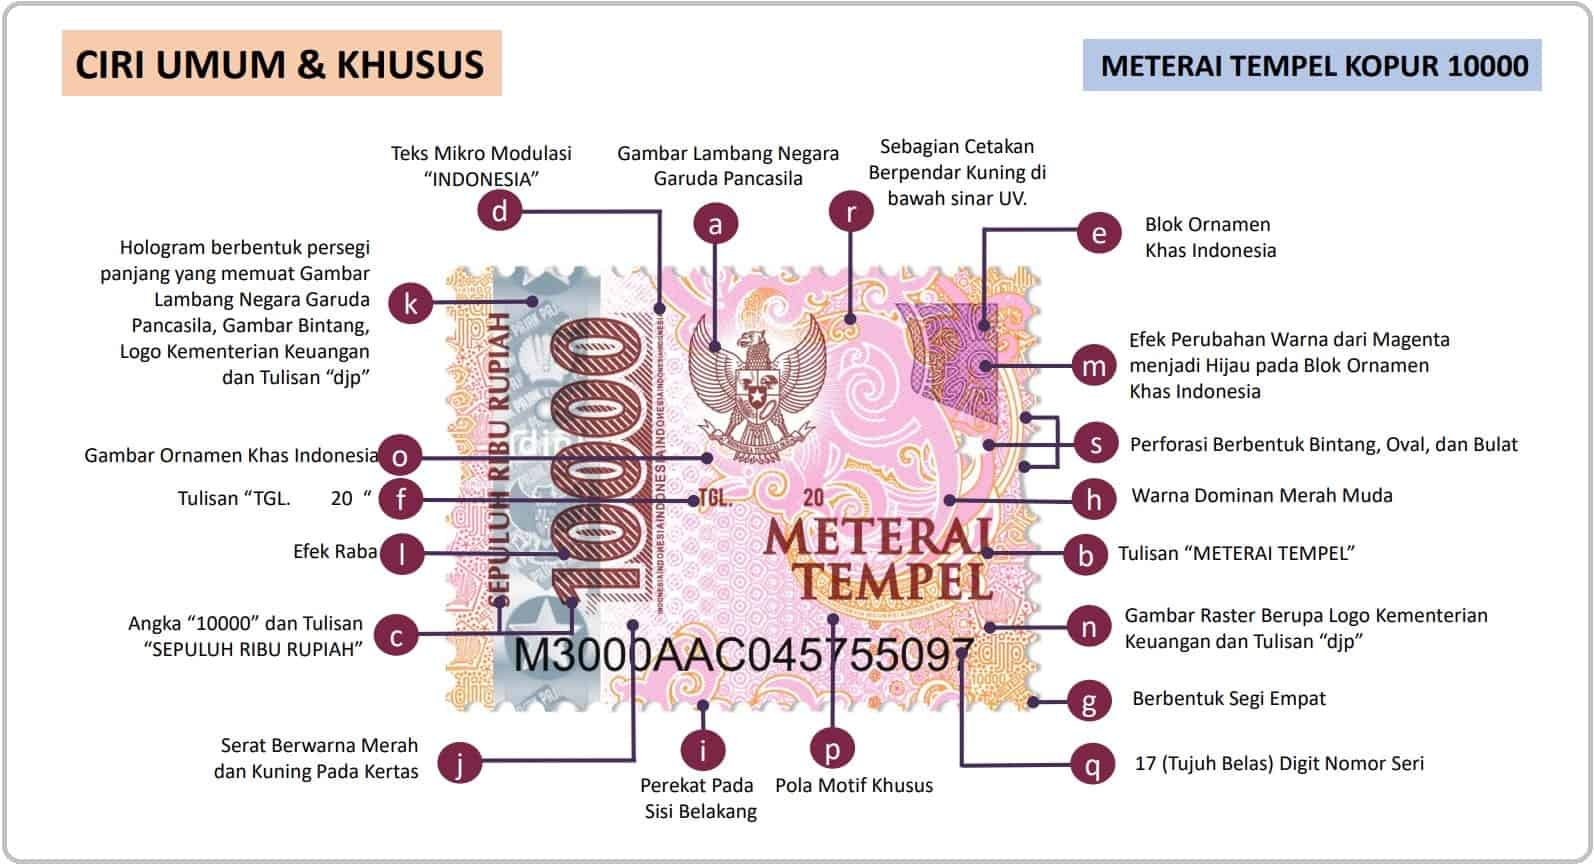

## **IMPORT LIBRARY YANG DIBUTUHKAN**

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path
from scipy import ndimage
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm

In [2]:
# Install library yang diperlukan di Google Colab
!pip install scikit-image opencv-python

## **PERSIAPAN DATASET**

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Netral"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Netral_clean"

process_batch_meterai(input_folder, output_folder)

🚀 Memproses 10 file...

[1/10] Processing: CamScanner 04-09-25 09.32_1.jpg
🔍 Ditemukan 46 kontur
  Kontur 0: area=49, bbox=8x8
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 1: area=6, bbox=4x3
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 2: area=49, bbox=8x8
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 3: area=50, bbox=6x12
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 4: area=25, bbox=6x6
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 5: area=6, bbox=4x3
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 6: area=4, bbox=3x3
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 7: area=27, bbox=10x4
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 8: area=393, bbox=32x22
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 9: area=22, bbox=5x7
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 10: area=45, bbox=16x4
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 11: area=280, bbox=56x8
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 12: area=4, bbox=3x3
    ❌ Area ratio tidak sesuai: 0.000
  Kontur 13: area=81404, 

## **DETEKSI MATERAI & AUGMENTASI**

In [ ]:
def detect_meterai_contour_fixed(image):
    """
    Deteksi kontur meterai dengan metode yang diperbaiki dan lebih permisif
    """
    # Konversi ke grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Metode 1: Threshold sederhana
    _, simple_thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

    # Metode 2: Adaptive threshold
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)

    # Metode 3: OTSU threshold
    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Kombinasi semua threshold
    combined_thresh = cv2.bitwise_or(simple_thresh, adaptive_thresh)
    combined_thresh = cv2.bitwise_or(combined_thresh, otsu_thresh)

    # Morphological operations lebih agresif
    kernel_large = np.ones((15,15), np.uint8)  # Kernel lebih besar
    kernel_medium = np.ones((7,7), np.uint8)
    kernel_small = np.ones((3,3), np.uint8)

    # Tutup gap yang besar
    combined_thresh = cv2.morphologyEx(combined_thresh, cv2.MORPH_CLOSE, kernel_large)
    combined_thresh = cv2.morphologyEx(combined_thresh, cv2.MORPH_CLOSE, kernel_medium)
    # Hilangkan noise kecil
    combined_thresh = cv2.morphologyEx(combined_thresh, cv2.MORPH_OPEN, kernel_small)

    # Cari kontur
    contours, _ = cv2.findContours(combined_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        # print("⚠️  Tidak ada kontur yang ditemukan")
        return None, combined_thresh

    # print(f"🔍 Ditemukan {len(contours)} kontur")

    # Filter kontur dengan kriteria yang lebih permisif
    valid_contours = []
    image_area = image.shape[0] * image.shape[1]

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        # print(f"  Kontur {i}: area={area:.0f}, bbox={w}x{h}")

        # Filter berdasarkan area yang lebih permisif
        area_ratio = area / image_area
        if 0.005 < area_ratio < 0.9:  # 0.5% - 90% dari total gambar (lebih permisif)
            aspect_ratio = w / h
            if 0.2 < aspect_ratio < 5.0:  # Aspect ratio lebih permisif
                rect_area = w * h
                extent = area / rect_area if rect_area > 0 else 0

                if extent > 0.1:  # Lebih permisif: kontur mengisi minimal 10% dari bounding box
                    valid_contours.append((contour, area, extent, w*h))
                    # print(f"    ✅ Valid: area_ratio={area_ratio:.3f}, aspect={aspect_ratio:.2f}, extent={extent:.2f}")
                else:
                    print(f"    ❌ Extent terlalu kecil: {extent:.2f}")
            else:
                print(f"    ❌ Aspect ratio tidak sesuai: {aspect_ratio:.2f}")
        else:
            print(f"    ❌ Area ratio tidak sesuai: {area_ratio:.3f}")

    if not valid_contours:
        print("⚠️  Tidak ada kontur valid yang ditemukan")
        # Fallback: ambil kontur terbesar tanpa filter ketat
        largest_contour = max(contours, key=cv2.contourArea)
        largest_area = cv2.contourArea(largest_contour)
        if largest_area > 100:  # Minimal 100 pixel
            print(f"🔄 Fallback: menggunakan kontur terbesar (area={largest_area:.0f})")
            return largest_contour, combined_thresh
        return None, combined_thresh

    # Pilih kontur terbaik berdasarkan area dan bounding box
    best_contour = max(valid_contours, key=lambda x: x[1])  # Pilih yang area terbesar
    print(f"✅ Kontur terbaik dipilih dengan area: {best_contour[1]:.0f}")

    return best_contour[0], combined_thresh

def crop_meterai_fixed(image, contour, padding=5):
    """
    Crop meterai dengan padding minimal
    """
    if contour is None:
        return None

    # Gunakan minimum area rectangle
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.array(box, dtype=int)  # Fixed: using np.array with dtype=int instead of np.int0

    # Dapatkan bounding box
    x_coords = box[:, 0]
    y_coords = box[:, 1]

    x_min = max(0, int(np.min(x_coords) - padding))
    x_max = min(image.shape[1], int(np.max(x_coords) + padding))
    y_min = max(0, int(np.min(y_coords) - padding))
    y_max = min(image.shape[0], int(np.max(y_coords) + padding))

    # Crop
    cropped = image[y_min:y_max, x_min:x_max]

    # Jika hasil terlalu kecil, gunakan bounding rectangle biasa
    if cropped.shape[0] < 50 or cropped.shape[1] < 50:
        x, y, w, h = cv2.boundingRect(contour)
        x = max(0, x - padding)
        y = max(0, y - padding)
        w = min(image.shape[1] - x, w + 2*padding)
        h = min(image.shape[0] - y, h + 2*padding)
        cropped = image[y:y+h, x:x+w]

    return cropped

# ==================== DATA AUGMENTATION METHODS ====================

def augment_brightness_contrast(image, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    """
    Augmentasi brightness dan contrast
    alpha: contrast (1.0 = no change)
    beta: brightness (0 = no change)
    """
    alpha = random.uniform(*alpha_range)
    beta = random.randint(*beta_range)

    augmented = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return augmented

def augment_rotation(image, angle_range=(-15, 15)):
    """
    Rotasi gambar dengan sudut acak
    """
    angle = random.uniform(*angle_range)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (width, height),
                            borderMode=cv2.BORDER_REFLECT_101)
    return rotated

def augment_noise(image, noise_type='gaussian', intensity=0.05):
    """
    Tambahkan noise pada gambar
    noise_type: 'gaussian' atau 'salt_pepper'
    """
    if noise_type == 'gaussian':
        noise = np.random.normal(0, intensity * 255, image.shape).astype(np.uint8)
        noisy = cv2.add(image, noise)
    elif noise_type == 'salt_pepper':
        noisy = image.copy()
        # Salt noise
        salt = np.random.random(image.shape[:2]) < intensity/2
        noisy[salt] = 255
        # Pepper noise
        pepper = np.random.random(image.shape[:2]) < intensity/2
        noisy[pepper] = 0

    return noisy

def augment_blur(image, blur_type='gaussian', kernel_size_range=(3, 7)):
    """
    Aplikasikan blur pada gambar
    """
    kernel_size = random.choice(range(kernel_size_range[0], kernel_size_range[1] + 1, 2))

    if blur_type == 'gaussian':
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    elif blur_type == 'motion':
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
        kernel = kernel / kernel_size
        blurred = cv2.filter2D(image, -1, kernel)

    return blurred

def augment_perspective(image, strength=0.1):
    """
    Transformasi perspektif untuk simulasi sudut pandang berbeda
    """
    height, width = image.shape[:2]

    # Titik-titik corner original
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Titik-titik corner setelah transformasi dengan random offset
    offset = int(min(width, height) * strength)
    pts2 = np.float32([
        [random.randint(0, offset), random.randint(0, offset)],
        [width - random.randint(0, offset), random.randint(0, offset)],
        [random.randint(0, offset), height - random.randint(0, offset)],
        [width - random.randint(0, offset), height - random.randint(0, offset)]
    ])

    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    transformed = cv2.warpPerspective(image, matrix, (width, height),
                                    borderMode=cv2.BORDER_REFLECT_101)
    return transformed

def augment_color_shift(image, hue_shift_range=(-10, 10), sat_shift_range=(-20, 20)):
    """
    Perubahan warna dengan mengubah HSV
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)

    # Hue shift
    hue_shift = random.randint(*hue_shift_range)
    hsv[:, :, 0] = (hsv[:, :, 0] + hue_shift) % 180

    # Saturation shift
    sat_shift = random.randint(*sat_shift_range)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] + sat_shift, 0, 255)

    augmented = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return augmented

def augment_rotation(image, angle_range=(-10, 10)):
    """Rotasi dengan range yang lebih kecil"""
    angle = random.uniform(*angle_range)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (width, height),
                            borderMode=cv2.BORDER_REFLECT_101)
    return rotated

def augment_translation(image, max_shift=0.1):
    """Translasi gambar"""
    height, width = image.shape[:2]

    # Maksimal shift dalam persentase
    max_dx = int(width * max_shift)
    max_dy = int(height * max_shift)

    dx = random.randint(-max_dx, max_dx)
    dy = random.randint(-max_dy, max_dy)

    translation_matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    translated = cv2.warpAffine(image, translation_matrix, (width, height),
                               borderMode=cv2.BORDER_REFLECT_101)
    return translated

def augment_scale(image, scale_range=(0.9, 1.1)):
    """Scaling dengan range terbatas"""
    scale = random.uniform(*scale_range)
    height, width = image.shape[:2]
    center = (width // 2, height // 2)

    # Membuat matrix transformasi dengan scaling
    scale_matrix = cv2.getRotationMatrix2D(center, 0, scale)
    scaled = cv2.warpAffine(image, scale_matrix, (width, height),
                           borderMode=cv2.BORDER_REFLECT_101)
    return scaled

def augment_flip(image):
    """Flip horizontal atau vertical secara random"""
    flip_type = random.choice([0, 1, -1])  # 0=vertical, 1=horizontal, -1=both
    flipped = cv2.flip(image, flip_type)
    return flipped

def augment_shear(image, shear_range=(-5, 5)):
    """Transformasi shear"""
    shear_x = random.uniform(*shear_range) * np.pi / 180
    shear_y = random.uniform(*shear_range) * np.pi / 180

    height, width = image.shape[:2]

    # Matrix untuk shear transformation
    shear_matrix = np.float32([
        [1, np.tan(shear_x), 0],
        [np.tan(shear_y), 1, 0]
    ])

    sheared = cv2.warpAffine(image, shear_matrix, (width, height),
                            borderMode=cv2.BORDER_REFLECT_101)
    return sheared

def augment_mild_perspective(image, strength=0.02):
    """Transformasi perspektif yang sangat ringan"""
    height, width = image.shape[:2]

    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Offset yang lebih kecil
    offset = int(min(width, height) * strength)
    pts2 = np.float32([
        [random.randint(0, offset), random.randint(0, offset)],
        [width - random.randint(0, offset), random.randint(0, offset)],
        [random.randint(0, offset), height - random.randint(0, offset)],
        [width - random.randint(0, offset), height - random.randint(0, offset)]
    ])

    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    transformed = cv2.warpPerspective(image, matrix, (width, height),
                                    borderMode=cv2.BORDER_REFLECT_101)
    return transformed

# Augmentasi intensitas yang lebih ringan (jika diperlukan)
def augment_mild_brightness(image, beta_range=(-10, 10)):
    """Brightness adjustment yang ringan"""
    beta = random.randint(*beta_range)
    augmented = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
    return augmented

def augment_mild_noise(image, noise_type='gaussian', intensity=0.01):
    """Noise yang sangat minimal"""
    if noise_type == 'gaussian':
        noise = np.random.normal(0, intensity * 255, image.shape).astype(np.int16)
        noisy = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return noisy

def augment_mild_blur(image, kernel_size=3):
    """Blur yang sangat ringan"""
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0.5)
    return blurred

def apply_random_augmentation(image, num_augmentations=1):
    """
    Aplikasikan augmentasi acak pada gambar
    """
    augmentation_functions = [
        # lambda img: augment_brightness_contrast(img),
        lambda img: augment_rotation(img),
        lambda img: augment_noise(img, 'gaussian', 0.05),
        lambda img: augment_noise(img, 'salt_pepper', 0.02),
        lambda img: augment_blur(img, 'gaussian'),
        lambda img: augment_blur(img, 'motion'),
        lambda img: augment_perspective(img, 0.05),
        lambda img: augment_color_shift(img)
    ]

    result = image.copy()
    selected_augmentations = random.sample(augmentation_functions, min(num_augmentations, len(augmentation_functions)))

    for aug_func in selected_augmentations:
        result = aug_func(result)

    return result

def apply_geometric_augmentation_only(image, num_augmentations=1):
    """
    Hanya augmentasi geometrik yang tidak mengubah pixel values
    Cocok untuk ekstraksi fitur berbasis gradien/edge
    """
    geometric_augmentations = [
        lambda img: augment_rotation(img, angle_range=(-8, 8)),
        lambda img: augment_translation(img, max_shift=0.1),
        lambda img: augment_scale(img, scale_range=(0.9, 1.1)),
        lambda img: augment_flip(img),
        lambda img: augment_mild_perspective(img, strength=0.02),
        lambda img: augment_shear(img, shear_range=(-5, 5))
    ]

    result = image.copy()
    selected_augmentations = random.sample(
        geometric_augmentations,
        min(num_augmentations, len(geometric_augmentations))
    )

    for aug_func in selected_augmentations:
        result = aug_func(result)

    return result

def generate_augmented_dataset(cropped_image, num_variations=5):
    """
    Generate multiple augmented versions dari satu cropped image
    """
    augmented_images = []

    for i in range(num_variations):
        # Aplikasikan 1-3 augmentasi secara acak
        num_augs = random.randint(1, 3)
        augmented = apply_geometric_augmentation_only(cropped_image, num_augs)
        augmented_images.append(augmented)

    return augmented_images

# ==================== UPDATED PROCESSING FUNCTIONS ====================

def test_single_image(image_path):
    """
    Test cropping pada satu gambar
    """
    print(f"📸 Memproses: {image_path}")

    # Baca gambar
    image = cv2.imread(image_path)
    if image is None:
        print("❌ Gagal membaca gambar!")
        return None, None, None

    print(f"📏 Ukuran gambar original: {image.shape[1]}x{image.shape[0]}")

    # Deteksi kontur
    contour, debug_thresh = detect_meterai_contour_fixed(image)

    if contour is None:
        print("❌ Meterai tidak terdeteksi!")
        return image, None, debug_thresh

    # Gambar preview dengan kontur
    preview = image.copy()
    cv2.drawContours(preview, [contour], -1, (0, 255, 0), 3)

    # Gambar bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(preview, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Gambar minimum area rectangle
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.array(box, dtype=int)  # Fixed: using np.array with dtype=int instead of np.int0
    cv2.drawContours(preview, [box], 0, (0, 0, 255), 2)

    # Crop meterai
    cropped = crop_meterai_fixed(image, contour)

    if cropped is not None:
        print(f"✅ Berhasil crop! Ukuran hasil: {cropped.shape[1]}x{cropped.shape[0]}")
        area = cv2.contourArea(contour)
        print(f"📊 Area kontur: {area:.0f} pixels")
    else:
        print("❌ Gagal crop!")

    return preview, cropped, debug_thresh

def display_results(preview, cropped, debug_thresh):
    """
    Tampilkan hasil dengan matplotlib
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Preview dengan kontur
    if preview is not None:
        axes[0].imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Detection Preview\n(Hijau=Kontur, Biru=BoundingBox, Merah=MinAreaRect)', fontsize=10)
        axes[0].axis('off')

    # Debug threshold
    if debug_thresh is not None:
        axes[1].imshow(debug_thresh, cmap='gray')
        axes[1].set_title('Binary Threshold Debug', fontsize=10)
        axes[1].axis('off')

    # Hasil crop
    if cropped is not None:
        axes[2].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f'Cropped Result\n{cropped.shape[1]}x{cropped.shape[0]} pixels', fontsize=10)
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, 'CROPPING FAILED', ha='center', va='center',
                    transform=axes[2].transAxes, fontsize=16, color='red')
        axes[2].set_title('Cropped Result - FAILED', fontsize=10)
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def display_augmentation_samples(original_cropped, augmented_images):
    """
    Tampilkan hasil augmentasi
    """
    num_images = len(augmented_images) + 1
    cols = min(4, num_images)
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    # Original
    axes[0, 0].imshow(cv2.cvtColor(original_cropped, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Original Cropped', fontsize=10)
    axes[0, 0].axis('off')

    # Augmented versions
    for i, aug_img in enumerate(augmented_images):
        row = (i + 1) // cols
        col = (i + 1) % cols
        axes[row, col].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(f'Augmented #{i+1}', fontsize=10)
        axes[row, col].axis('off')

    # Hide extra subplots
    for i in range(num_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5, max_files=None):
    """
    Proses batch dengan augmentasi data
    """
    os.makedirs(output_folder, exist_ok=True)

    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    files = [f for f in os.listdir(input_folder)
             if any(f.lower().endswith(ext) for ext in image_extensions)]

    if max_files:
        files = files[:max_files]

    print(f"🚀 Memproses {len(files)} file dengan {augmentations_per_image} augmentasi per file...")
    print(f"📊 Total output yang diharapkan: {len(files) * (augmentations_per_image + 1)} gambar")

    success_count = 0
    failed_count = 0
    total_generated = 0

    for i, filename in enumerate(files, 1):
        print(f"\n[{i}/{len(files)}] Processing: {filename}")

        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(filename)[0]

        try:
            image = cv2.imread(input_path)
            if image is None:
                print(f"❌ Gagal membaca: {filename}")
                failed_count += 1
                continue

            contour, _ = detect_meterai_contour_fixed(image)

            if contour is None:
                print(f"⚠️  Meterai tidak terdeteksi: {filename}")
                failed_count += 1
                continue

            cropped = crop_meterai_fixed(image, contour)

            if cropped is None:
                print(f"❌ Gagal crop: {filename}")
                failed_count += 1
                continue

            # Simpan cropped original
            original_output = os.path.join(output_folder, f"{base_name}_original.jpg")
            cv2.imwrite(original_output, cropped)
            total_generated += 1

            # Generate augmented versions
            augmented_images = generate_augmented_dataset(cropped, augmentations_per_image)

            for j, aug_img in enumerate(augmented_images):
                aug_output = os.path.join(output_folder, f"{base_name}_aug_{j+1}.jpg")
                cv2.imwrite(aug_output, aug_img)
                total_generated += 1

            success_count += 1
            print(f"✅ {filename} -> Generated {augmentations_per_image + 1} images")

        except Exception as e:
            print(f"❌ Error: {filename} - {str(e)}")
            failed_count += 1

    print(f"\n📊 Ringkasan:")
    print(f"✅ File berhasil diproses: {success_count}")
    print(f"❌ File gagal: {failed_count}")
    print(f"🖼️  Total gambar dihasilkan: {total_generated}")
    print(f"📁 File output di: {output_folder}")

# # Contoh penggunaan
# if __name__ == "__main__":
#     # Test single image dengan augmentasi
#     image_path = "/path/to/your/image.jpg"
#     preview, cropped, debug_thresh = test_single_image(image_path)

#     if cropped is not None:
#         # Display original results
#         display_results(preview, cropped, debug_thresh)

#         # Generate dan display augmented versions
#         augmented_images = generate_augmented_dataset(cropped, 5)
#         display_augmentation_samples(cropped, augmented_images)

#     # Proses batch dengan augmentasi
#     # process_batch_meterai_with_augmentation(
#     #     input_folder="/path/to/input/folder",
#     #     output_folder="/path/to/output/folder",
#     #     augmentations_per_image=5,
#     #     max_files=10
#     # )

📸 Memproses: /content/drive/MyDrive/DATASET MATERAI/Palsu/netral/palsu-netral_10.jpg
📏 Ukuran gambar original: 2332x3156
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesua

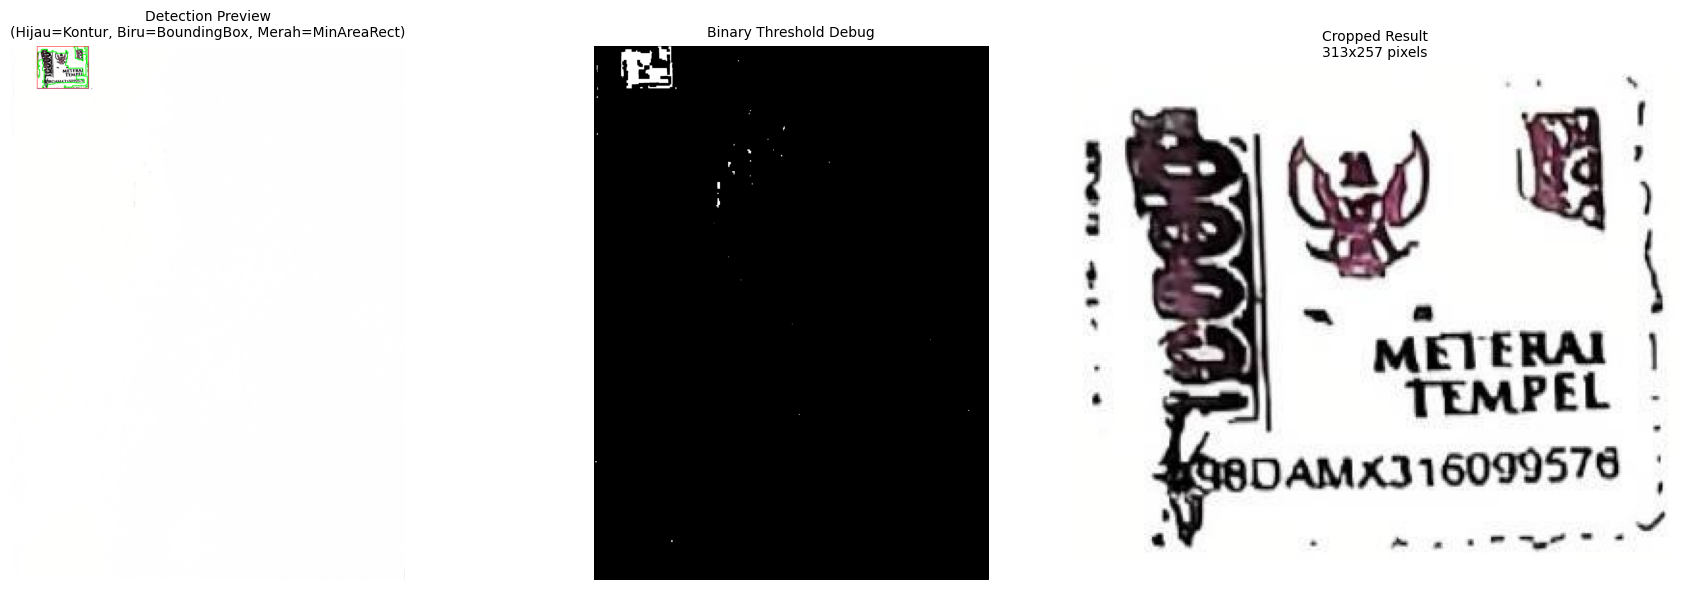

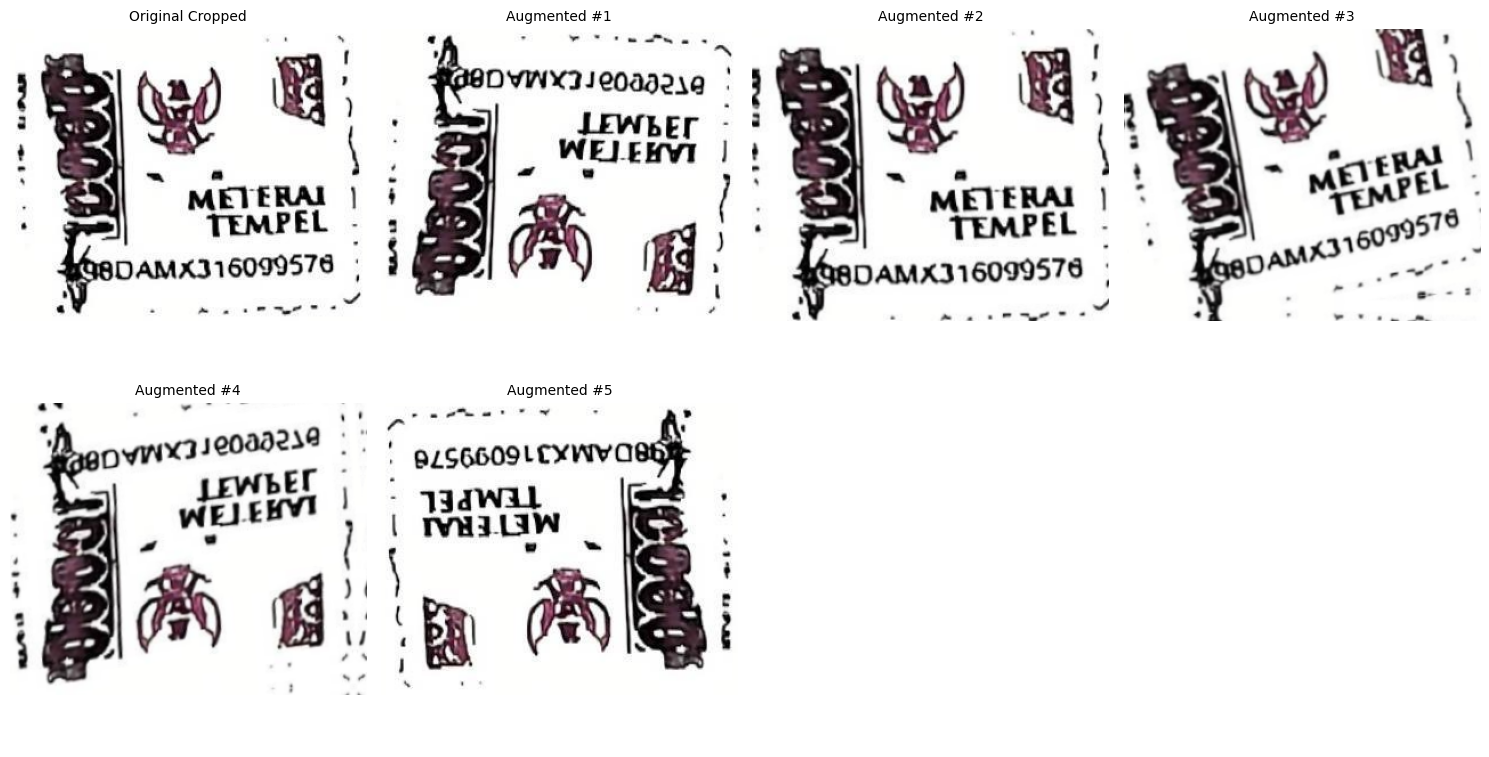

In [ ]:
image_path = "/content/drive/MyDrive/DATASET MATERAI/Palsu/netral/palsu-netral_10.jpg"
preview, cropped, debug_thresh = test_single_image(image_path)

if cropped is not None:
# Display original results
  display_results(preview, cropped, debug_thresh)
  augmented_images = generate_augmented_dataset(cropped, 5)
  display_augmentation_samples(cropped, augmented_images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/netral"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/netral/netral_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: Materai.png
    ❌ Area ratio tidak sesuai: 0.003
    ❌ Area ratio tidak sesuai: 0.002
    ❌ Area ratio tidak sesuai: 0.003
✅ Kontur terbaik dipilih dengan area: 87315
✅ Materai.png -> Generated 6 images

[2/10] Processing: materai_palsu.png
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
✅ Kontur terbaik dipilih dengan area: 271696
✅ materai_palsu.png -> Generated 6 images

[3/10] Processing: palsu-netral_2.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
 

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Netral"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Augmented_Netral_Dataset"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 04-09-25 09.32_1.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ✅ Valid: area_ratio=0.010, aspect=1.32, extent=0.64
    ❌ Area ratio tidak sesuai: 0.001
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tida

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/flashapp"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/flashapp/flashapp_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 07-09-25 09.32_1.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
   

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/flashexternal"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Palsu/flashexternal/flashexternal_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 07-09-25 09.36_2.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
   

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/flash app"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/flash app/flash app_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 04-09-25 09.36_5.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
✅ Kontur terbaik dipilih dengan area: 54751
✅ CamScanner 04-09-25 09.36_5.jpg -> Generated 6 images

[2/10] Processing: CamScanner 04-09-25 09.36_10.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.00

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/flash external"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/flash external/flash external_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 04-09-25 09.39_1 - Copy.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
✅ Kontur terbaik dipilih dengan area: 54564
✅ CamScanner 04-09-25 09.39_1 - Copy.jpg -> Generated 6 images

[2/10] Processing: CamScanner 04-09-25 09.39_2.jpg
    ❌ Area ratio tidak

In [ ]:
input_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/Netral"
output_folder = "/content/drive/MyDrive/DATASET MATERAI/Asli/Netral/netral_clean"

process_batch_meterai_with_augmentation(input_folder, output_folder, augmentations_per_image=5,max_files=10)

🚀 Memproses 10 file dengan 5 augmentasi per file...
📊 Total output yang diharapkan: 60 gambar

[1/10] Processing: CamScanner 04-09-25 09.32_1.jpg
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.001
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
    ❌ Area ratio tidak sesuai: 0.000
   

## **EKSTRAKSI FITUR GLCM DAN LBP**

### NOTES : YANG INI ERROR

In [ ]:
# Import dengan error handling
try:
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
    from skimage.measure import shannon_entropy
    SKIMAGE_AVAILABLE = True
    print("✓ scikit-image berhasil diimport")
except ImportError:
    print("⚠ scikit-image tidak tersedia, menggunakan implementasi manual")
    SKIMAGE_AVAILABLE = False

# Implementasi manual GLCM dan LBP jika scikit-image tidak tersedia
def manual_shannon_entropy(data):
    """Implementasi manual shannon entropy"""
    _, counts = np.unique(data, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-7))

def manual_glcm(image, distance=1, angle=0, levels=256):
    """Implementasi manual GLCM"""
    rows, cols = image.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # Hitung offset berdasarkan sudut
    if angle == 0:  # 0 derajat
        row_offset, col_offset = 0, distance
    elif angle == 45:  # 45 derajat
        row_offset, col_offset = -distance, distance
    elif angle == 90:  # 90 derajat
        row_offset, col_offset = -distance, 0
    elif angle == 135:  # 135 derajat
        row_offset, col_offset = -distance, -distance

    # Hitung co-occurrence matrix
    for i in range(rows):
        for j in range(cols):
            if (0 <= i + row_offset < rows) and (0 <= j + col_offset < cols):
                pixel1 = image[i, j]
                pixel2 = image[i + row_offset, j + col_offset]
                glcm[pixel1, pixel2] += 1

    # Normalisasi
    glcm = glcm / np.sum(glcm) if np.sum(glcm) > 0 else glcm
    return glcm

def calculate_glcm_features(glcm):
    """Hitung fitur dari GLCM"""
    # Contrast
    i, j = np.meshgrid(range(glcm.shape[0]), range(glcm.shape[1]), indexing='ij')
    contrast = np.sum(glcm * (i - j) ** 2)

    # Dissimilarity
    dissimilarity = np.sum(glcm * np.abs(i - j))

    # Homogeneity (Inverse Difference Moment)
    homogeneity = np.sum(glcm / (1 + (i - j) ** 2))

    # Energy (Angular Second Moment)
    energy = np.sum(glcm ** 2)

    # Correlation
    mu_i = np.sum(i * glcm)
    mu_j = np.sum(j * glcm)
    sigma_i = np.sqrt(np.sum(((i - mu_i) ** 2) * glcm))
    sigma_j = np.sqrt(np.sum(((j - mu_j) ** 2) * glcm))

    if sigma_i > 0 and sigma_j > 0:
        correlation = np.sum(((i - mu_i) * (j - mu_j) * glcm)) / (sigma_i * sigma_j)
    else:
        correlation = 0

    return {
        'contrast': contrast,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'energy': energy,
        'correlation': correlation,
        'ASM': energy  # ASM sama dengan energy
    }

def manual_lbp(image, radius=3, n_points=24):
    """Implementasi manual LBP"""
    rows, cols = image.shape
    # Use uint16 to handle potentially larger LBP codes
    lbp = np.zeros((rows, cols), dtype=np.int32)

    for i in range(radius, rows - radius):
        for j in range(radius, cols - radius):
            center = image[i, j]
            code = 0

            for p in range(n_points):
                # Hitung koordinat titik sampling
                angle = 2 * np.pi * p / n_points
                x = i + radius * np.cos(angle)
                y = j - radius * np.sin(angle)

                # Interpolasi bilinear
                x1, y1 = int(np.floor(x)), int(np.floor(y))
                x2, y2 = min(x1 + 1, rows - 1), min(y1 + 1, cols - 1)

                if x1 >= 0 and y1 >= 0 and x2 < rows and y2 < cols:
                    # Interpolasi bilinear
                    wa = (x2 - x) * (y2 - y)
                    wb = (x2 - x) * (y - y1)
                    wc = (x - x1) * (y2 - y)
                    wd = (x - x1) * (y - y1)

                    interpolated = (wa * image[x1, y1] + wb * image[x1, y2] +
                                  wc * image[x2, y1] + wd * image[x2, y2])

                    if interpolated >= center:
                        code |= (1 << p)

            lbp[i, j] = code

    return lbp

class MateraiFeatureExtractor:
    def __init__(self):
        self.features_list = []
        self.labels = []

    def extract_rgb_features(self, image):
        """
        Ekstraksi fitur statistik RGB
        """
        # Pisahkan channel RGB
        b, g, r = cv2.split(image)

        rgb_features = {}
        channels = {'R': r, 'G': g, 'B': b}

        for channel_name, channel in channels.items():
            # Statistik dasar
            rgb_features[f'{channel_name}_mean'] = np.mean(channel)
            rgb_features[f'{channel_name}_std'] = np.std(channel)
            rgb_features[f'{channel_name}_var'] = np.var(channel)
            rgb_features[f'{channel_name}_min'] = np.min(channel)
            rgb_features[f'{channel_name}_max'] = np.max(channel)
            rgb_features[f'{channel_name}_median'] = np.median(channel)
            rgb_features[f'{channel_name}_skewness'] = self.calculate_skewness(channel)
            rgb_features[f'{channel_name}_kurtosis'] = self.calculate_kurtosis(channel)

            # Histogram features
            hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
            hist = hist.flatten() / hist.sum()  # Normalisasi
            if SKIMAGE_AVAILABLE:
                rgb_features[f'{channel_name}_entropy'] = shannon_entropy(hist)
            else:
                rgb_features[f'{channel_name}_entropy'] = manual_shannon_entropy(channel)

        # Fitur antar channel
        rgb_features['RG_correlation'] = np.corrcoef(r.flatten(), g.flatten())[0,1]
        rgb_features['RB_correlation'] = np.corrcoef(r.flatten(), b.flatten())[0,1]
        rgb_features['GB_correlation'] = np.corrcoef(g.flatten(), b.flatten())[0,1]

        # Dominansi warna
        rgb_features['R_dominance'] = np.mean(r) / (np.mean(r) + np.mean(g) + np.mean(b))
        rgb_features['G_dominance'] = np.mean(g) / (np.mean(r) + np.mean(g) + np.mean(b))
        rgb_features['B_dominance'] = np.mean(b) / (np.mean(r) + np.mean(g) + np.mean(b))

        return rgb_features

    def calculate_skewness(self, data):
        """Menghitung skewness"""
        mean = np.mean(data)
        std = np.std(data)
        return np.mean(((data - mean) / std) ** 3)

    def calculate_kurtosis(self, data):
        """Menghitung kurtosis"""
        mean = np.mean(data)
        std = np.std(data)
        return np.mean(((data - mean) / std) ** 4) - 3

    def extract_glcm_features(self, image, distances=[1, 2, 3], angles=[0, 45, 90, 135]):
        """
        Ekstraksi fitur tekstur menggunakan GLCM (Gray Level Co-occurrence Matrix)
        """
        # Konversi ke grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        glcm_features = {}

        if SKIMAGE_AVAILABLE:
            # Kuantisasi ke 64 level untuk efisiensi komputasi
            gray = (gray / 4).astype(np.uint8)

            # Konversi sudut ke radian
            angles_rad = [np.deg2rad(angle) for angle in angles]

            # Hitung GLCM untuk berbagai jarak dan sudut
            glcm = greycomatrix(gray, distances=distances, angles=angles_rad,
                               levels=64, symmetric=True, normed=True)

            # Ekstraksi properti GLCM
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

            for prop in properties:
                values = greycoprops(glcm, prop)
                # Ambil rata-rata dari semua jarak dan sudut
                glcm_features[f'GLCM_{prop}_mean'] = np.mean(values)
                glcm_features[f'GLCM_{prop}_std'] = np.std(values)
                glcm_features[f'GLCM_{prop}_max'] = np.max(values)
                glcm_features[f'GLCM_{prop}_min'] = np.min(values)
        else:
            # Implementasi manual GLCM
            print("Menggunakan implementasi manual GLCM...")

            # Kuantisasi ke 64 level
            gray = (gray / 4).astype(np.uint8)

            all_features = []
            for distance in distances:
                for angle in angles:
                    glcm = manual_glcm(gray, distance=distance, angle=angle, levels=64)
                    features = calculate_glcm_features(glcm)
                    all_features.append(features)

            # Hitung statistik dari semua kombinasi jarak dan sudut
            feature_names = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for feature_name in feature_names:
                values = [f[feature_name] for f in all_features]
                glcm_features[f'GLCM_{feature_name}_mean'] = np.mean(values)
                glcm_features[f'GLCM_{feature_name}_std'] = np.std(values)
                glcm_features[f'GLCM_{feature_name}_max'] = np.max(values)
                glcm_features[f'GLCM_{feature_name}_min'] = np.min(values)

        return glcm_features

    def extract_lbp_features(self, image, radius=3, n_points=24, method='uniform'):
        """
        Ekstraksi fitur tekstur menggunakan LBP (Local Binary Pattern)
        """
        # Konversi ke grayscale
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image.copy()

        if SKIMAGE_AVAILABLE:
            # Hitung LBP menggunakan scikit-image
            lbp = local_binary_pattern(gray, n_points, radius, method=method)

            # Hitung histogram LBP
            n_bins = n_points + 2 if method == 'uniform' else 2**n_points
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float)
            hist /= (hist.sum() + 1e-7)  # Normalisasi
        else:
            # Implementasi manual LBP
            print("Menggunakan implementasi manual LBP...")
            lbp = manual_lbp(gray, radius=radius, n_points=n_points)

            # Hitung histogram LBP
            # Adjust n_bins based on potential max LBP value for uint16 (65536)
            n_bins = 2**n_points if n_points <= 16 else 65536 # Use 2^n_points or max uint16
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float)
            hist /= (hist.sum() + 1e-7)  # Normalisasi

        lbp_features = {}

        # Fitur dari histogram LBP
        lbp_features['LBP_uniformity'] = np.sum(hist**2)
        if SKIMAGE_AVAILABLE:
            lbp_features['LBP_entropy'] = shannon_entropy(hist)
        else:
            lbp_features['LBP_entropy'] = manual_shannon_entropy(lbp)

        # Statistik dari LBP image
        lbp_features['LBP_mean'] = np.mean(lbp)
        lbp_features['LBP_std'] = np.std(lbp)
        lbp_features['LBP_var'] = np.var(lbp)
        lbp_features['LBP_skewness'] = self.calculate_skewness(lbp)
        lbp_features['LBP_kurtosis'] = self.calculate_kurtosis(lbp)

        # Bin histogram sebagai fitur (ambil beberapa bin pertama untuk mengurangi dimensi)
        # Adjust range if needed, depending on the actual range of LBP values
        num_bins_to_use = min(50, len(hist)) # Use up to 50 bins or less if hist is smaller
        for i in range(num_bins_to_use):
            lbp_features[f'LBP_hist_bin_{i}'] = hist[i]

        return lbp_features, lbp

    def extract_all_features(self, image_path, label):
        """
        Ekstraksi semua fitur dari satu gambar
        """
        # Baca gambar
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Tidak dapat membaca gambar {image_path}")
            return None, None

        # Ekstraksi fitur RGB
        rgb_features = self.extract_rgb_features(image)

        # Ekstraksi fitur GLCM
        glcm_features = self.extract_glcm_features(image)

        # Ekstraksi fitur LBP
        lbp_features, lbp_image = self.extract_lbp_features(image)

        # Gabungkan semua fitur
        all_features = {**rgb_features, **glcm_features, **lbp_features}
        all_features['label'] = label
        all_features['image_path'] = image_path

        return all_features, lbp_image

    def process_dataset(self, dataset_path, save_features=True):
        """
        Proses seluruh dataset
        Struktur folder:
        dataset_path/
        ├── asli/
        └── palsu/
        """
        features_data = []

        # Proses materai asli
        asli_path = os.path.join(dataset_path, 'asli')
        if os.path.exists(asli_path):
            print("Memproses materai asli...")
            for filename in os.listdir(asli_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(asli_path, filename)
                    features, _ = self.extract_all_features(image_path, 'asli')
                    if features:
                        features_data.append(features)
                        print(f"✓ Processed: {filename}")

        # Proses materai palsu
        palsu_path = os.path.join(dataset_path, 'palsu')
        if os.path.exists(palsu_path):
            print("\nMemproses materai palsu...")
            for filename in os.listdir(palsu_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(palsu_path, filename)
                    features, _ = self.extract_all_features(image_path, 'palsu')
                    if features:
                        features_data.append(features)
                        print(f"✓ Processed: {filename}")

        # Konversi ke DataFrame
        df_features = pd.DataFrame(features_data)

        if save_features and len(df_features) > 0:
            # Simpan ke CSV
            df_features.to_csv('materai_features.csv', index=False)
            print(f"\n🎉 EKSTRAKSI SELESAI!")
            print(f"📊 Total gambar: {len(features_data)}")
            print(f"🔢 Total fitur per gambar: {len(df_features.columns)-2}")
            print(f"💾 Dataset fitur disimpan: 'materai_features.csv'")

            # Tampilkan ringkasan
            print(f"\n📈 DISTRIBUSI DATA:")
            print(df_features['label'].value_counts())

        return df_features

    def visualize_sample_processing(self, image_path):
        """
        Visualisasi proses ekstraksi fitur untuk satu gambar sampel
        """
        # Baca gambar
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Gambar tidak ditemukan di {image_path}")
            return None, None

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Konversi ke grayscale for LBP
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Ekstraksi LBP
        lbp_features, lbp_image = self.extract_lbp_features(image)

        # Visualisasi
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Gambar asli
        axes[0, 0].imshow(image_rgb)
        axes[0, 0].set_title('Gambar Asli')
        axes[0, 0].axis('off')

        # Channel R, G, B
        channels = ['R', 'G', 'B']
        colors = ['Reds', 'Greens', 'Blues']

        for i, color in enumerate(colors):
            channel_data = image_rgb[:, :, i]
            axes[0, i].imshow(channel_data, cmap=color)
            axes[0, i].set_title(f'Channel {channels[i]}')
            axes[0, i].axis('off')


        # Grayscale
        axes[1, 0].imshow(gray, cmap='gray')
        axes[1, 0].set_title('Grayscale')
        axes[1, 0].axis('off')

        # LBP
        # Ensure LBP image data is suitable for imshow (e.g., scale to 0-255 if needed)
        lbp_display = lbp_image.astype(np.uint8) if lbp_image.max() <= 255 else (lbp_image / lbp_image.max() * 255).astype(np.uint8)
        axes[1, 1].imshow(lbp_display, cmap='gray')
        axes[1, 1].set_title('LBP Pattern')
        axes[1, 1].axis('off')


        # Histogram LBP
        # Calculate histogram directly from the lbp_image (uint16)
        hist, bins = np.histogram(lbp_image.ravel(), bins=256) # Use a fixed number of bins or adjust based on actual range
        axes[1, 2].plot(bins[:-1], hist)
        axes[1, 2].set_title('Histogram LBP')
        axes[1, 2].set_xlabel('Nilai LBP')
        axes[1, 2].set_ylabel('Frekuensi')

        plt.tight_layout()
        plt.show()

        return image_rgb, lbp_image

    def analyze_features(self, df_features):
        """
        Analisis statistik fitur yang telah diekstrak
        """
        if len(df_features) == 0:
            print("❌ Dataset kosong!")
            return None

        # Pisahkan fitur numerik
        feature_cols = [col for col in df_features.columns if col not in ['label', 'image_path']]

        print("=== 📊 ANALISIS FITUR MATERAI ===\n")
        print(f"📷 Total gambar: {len(df_features)}")
        print(f"🔢 Total fitur: {len(feature_cols)}")
        print(f"🏷️  Distribusi label: {df_features['label'].value_counts().to_dict()}\n")

        # Statistik per kelas
        stats_by_class = df_features.groupby('label')[feature_cols].agg(['mean', 'std']).round(4)

        # Fitur dengan perbedaan terbesar antara asli dan palsu
        print("=== 🎯 FITUR PEMBEDA TERBESAR ===")
        if 'asli' in df_features['label'].values and 'palsu' in df_features['label'].values:
            asli_mean = df_features[df_features['label'] == 'asli'][feature_cols].mean()
            palsu_mean = df_features[df_features['label'] == 'palsu'][feature_cols].mean()

            # Hitung selisih relatif
            # Handle division by zero or very small numbers
            diff = abs((asli_mean - palsu_mean) / (asli_mean.abs() + palsu_mean.abs() + 1e-7))
            top_features = diff.nlargest(10)

            for i, (feature, value) in enumerate(top_features.items(), 1):
                print(f"{i:2d}. {feature}: {value:.4f}")

        # Visualisasi distribusi beberapa fitur penting
        if len(top_features) > 0:
            self.plot_feature_distribution(df_features, top_features.index[:6])

        return stats_by_class

    def plot_feature_distribution(self, df_features, feature_names):
        """
        Plot distribusi fitur penting
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        for i, feature in enumerate(feature_names):
            if i < 6:  # Maksimal 6 plot
                asli_data = df_features[df_features['label'] == 'asli'][feature]
                palsu_data = df_features[df_features['label'] == 'palsu'][feature]

                axes[i].hist(asli_data, alpha=0.7, label='Asli', bins=20, color='green')
                axes[i].hist(palsu_data, alpha=0.7, label='Palsu', bins=20, color='red')
                axes[i].set_title(f'{feature}')
                axes[i].legend()
                axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

⚠ scikit-image tidak tersedia, menggunakan implementasi manual


### NOTES : PERBAIKAN (METHOD MANUAL)

In [ ]:
# === IMPORTS ===
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Optional: scikit-image
try:
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
    from skimage.measure import shannon_entropy
    SKIMAGE_AVAILABLE = True
    print("✓ scikit-image berhasil diimport")
except Exception:
    print("⚠ scikit-image tidak tersedia, menggunakan implementasi manual")
    SKIMAGE_AVAILABLE = False

# === UTILS / FALLBACK IMPLEMENTATIONS ===
def manual_shannon_entropy(data):
    """Manual Shannon entropy. Accepts 1D array or histogram."""
    arr = np.asarray(data).ravel()
    # if arr looks like histogram (sums to 1 or >1?), detect:
    if np.all(arr <= 1.0) and np.isclose(arr.sum(), 1.0, atol=1e-3):
        probs = arr
    else:
        _, counts = np.unique(arr, return_counts=True)
        probs = counts / counts.sum()
    probs = probs + 1e-12
    return -np.sum(probs * np.log2(probs))

def manual_glcm(image, distance=1, angle=0, levels=256):
    """Manual GLCM for given distance and angle(in degrees). Image must be integer levels [0..levels-1]."""
    rows, cols = image.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # compute offset based on angle (degrees)
    theta = math.radians(angle)
    d_row = int(round(-distance * math.sin(theta)))  # negative because row increases downward
    d_col = int(round(distance * math.cos(theta)))

    for i in range(rows):
        ni = i + d_row
        if ni < 0 or ni >= rows:
            continue
        for j in range(cols):
            nj = j + d_col
            if nj < 0 or nj >= cols:
                continue
            a = int(image[i, j])
            b = int(image[ni, nj])
            glcm[a, b] += 1

    s = glcm.sum()
    if s > 0:
        glcm = glcm / s
    return glcm

def calculate_glcm_features(glcm):
    """Compute standard GLCM features from normalized glcm."""
    L = glcm.shape[0]
    i, j = np.meshgrid(np.arange(L), np.arange(L), indexing='ij')
    # Contrast
    contrast = np.sum(glcm * (i - j) ** 2)
    # Dissimilarity
    dissimilarity = np.sum(glcm * np.abs(i - j))
    # Homogeneity
    homogeneity = np.sum(glcm / (1.0 + (i - j) ** 2))
    # ASM
    asm = np.sum(glcm ** 2)
    # Energy = sqrt(ASM)
    energy = math.sqrt(asm) if asm >= 0 else 0.0
    # Correlation
    mu_i = np.sum(i * glcm)
    mu_j = np.sum(j * glcm)
    sigma_i = math.sqrt(max(0.0, np.sum(((i - mu_i) ** 2) * glcm)))
    sigma_j = math.sqrt(max(0.0, np.sum(((j - mu_j) ** 2) * glcm)))
    if sigma_i > 0 and sigma_j > 0:
        correlation = np.sum(((i - mu_i) * (j - mu_j) * glcm)) / (sigma_i * sigma_j)
    else:
        correlation = 0.0

    return {
        'contrast': float(contrast),
        'dissimilarity': float(dissimilarity),
        'homogeneity': float(homogeneity),
        'energy': float(energy),
        'correlation': float(correlation),
        'ASM': float(asm)
    }

def manual_lbp(image, radius=3, n_points=24):
    """
    Manual LBP with bilinear interpolation.
    Returns integer-coded LBP image (dtype=np.int32).
    Note: this is slow in Python for large images; use scikit-image if available.
    """
    h, w = image.shape
    lbp = np.zeros((h, w), dtype=np.int32)

    for y in range(radius, h - radius):
        for x in range(radius, w - radius):
            center = image[y, x]
            code = 0
            for p in range(n_points):
                ang = 2.0 * math.pi * p / n_points
                # sample coordinate (float)
                sample_x = x + radius * math.cos(ang)
                sample_y = y - radius * math.sin(ang)  # minus because image y-axis goes down
                # bilinear interpolation
                x1 = int(math.floor(sample_x))
                y1 = int(math.floor(sample_y))
                x2 = min(x1 + 1, w - 1)
                y2 = min(y1 + 1, h - 1)
                if x1 < 0 or y1 < 0 or x1 >= w or y1 >= h:
                    continue
                wa = (x2 - sample_x) * (y2 - sample_y)
                wb = (x2 - sample_x) * (sample_y - y1)
                wc = (sample_x - x1) * (y2 - sample_y)
                wd = (sample_x - x1) * (sample_y - y1)
                interpolated = wa * image[y1, x1] + wb * image[y2, x1] + wc * image[y1, x2] + wd * image[y2, x2]
                if interpolated >= center:
                    code |= (1 << p)
            lbp[y, x] = code
    return lbp

# === FEATURE EXTRACTOR CLASS ===
class MateraiFeatureExtractor:
    def __init__(self):
        pass

    # safe stat helpers
    def calculate_skewness(self, data):
        arr = np.asarray(data).ravel().astype(float)
        std = arr.std()
        if std == 0 or np.isnan(std):
            return 0.0
        mean = arr.mean()
        return float(np.mean(((arr - mean) / std) ** 3))

    def calculate_kurtosis(self, data):
        arr = np.asarray(data).ravel().astype(float)
        std = arr.std()
        if std == 0 or np.isnan(std):
            return 0.0
        mean = arr.mean()
        return float(np.mean(((arr - mean) / std) ** 4) - 3.0)

    def safe_corr(self, a, b):
        a = np.asarray(a).ravel().astype(float)
        b = np.asarray(b).ravel().astype(float)
        if a.std() == 0 or b.std() == 0:
            return 0.0
        return float(np.corrcoef(a, b)[0, 1])

    def extract_rgb_features(self, image):
        b, g, r = cv2.split(image)
        rgb_features = {}
        channels = {'R': r, 'G': g, 'B': b}

        for channel_name, channel in channels.items():
            arr = channel.astype(float)
            rgb_features[f'{channel_name}_mean'] = float(np.mean(arr))
            rgb_features[f'{channel_name}_std'] = float(np.std(arr))
            rgb_features[f'{channel_name}_var'] = float(np.var(arr))
            rgb_features[f'{channel_name}_min'] = float(np.min(arr))
            rgb_features[f'{channel_name}_max'] = float(np.max(arr))
            rgb_features[f'{channel_name}_median'] = float(np.median(arr))
            rgb_features[f'{channel_name}_skewness'] = self.calculate_skewness(arr)
            rgb_features[f'{channel_name}_kurtosis'] = self.calculate_kurtosis(arr)

            # Histogram and entropy
            hist = cv2.calcHist([channel], [0], None, [256], [0, 256]).flatten()
            hist_norm = hist / (hist.sum() + 1e-12)
            if SKIMAGE_AVAILABLE:
                rgb_features[f'{channel_name}_entropy'] = float(shannon_entropy(hist_norm))
            else:
                rgb_features[f'{channel_name}_entropy'] = float(manual_shannon_entropy(hist_norm))

        # correlations
        rgb_features['RG_correlation'] = self.safe_corr(r.flatten(), g.flatten())
        rgb_features['RB_correlation'] = self.safe_corr(r.flatten(), b.flatten())
        rgb_features['GB_correlation'] = self.safe_corr(g.flatten(), b.flatten())

        # dominance
        r_mean = np.mean(r.astype(float))
        g_mean = np.mean(g.astype(float))
        b_mean = np.mean(b.astype(float))
        s = (r_mean + g_mean + b_mean) + 1e-12
        rgb_features['R_dominance'] = float(r_mean / s)
        rgb_features['G_dominance'] = float(g_mean / s)
        rgb_features['B_dominance'] = float(b_mean / s)

        return rgb_features

    def extract_glcm_features(self, image, distances=[1,2,3], angles=[0,45,90,135]):
        # grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image.copy()
        glcm_features = {}

        if SKIMAGE_AVAILABLE:
            # quantize to 64 levels
            gray_q = (gray / 4).astype(np.uint8)
            angles_rad = [math.radians(a) for a in angles]
            glcm = greycomatrix(gray_q, distances=distances, angles=angles_rad, levels=64, symmetric=True, normed=True)
            properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
            for prop in properties:
                values = greycoprops(glcm, prop)
                glcm_features[f'GLCM_{prop}_mean'] = float(np.mean(values))
                glcm_features[f'GLCM_{prop}_std'] = float(np.std(values))
                glcm_features[f'GLCM_{prop}_max'] = float(np.max(values))
                glcm_features[f'GLCM_{prop}_min'] = float(np.min(values))
        else:
            # manual
            gray_q = (gray / 4).astype(np.uint8)
            all_feats = []
            for d in distances:
                for ang in angles:
                    glcm = manual_glcm(gray_q, distance=d, angle=ang, levels=64)
                    feats = calculate_glcm_features(glcm)
                    all_feats.append(feats)
            # aggregate stats
            keys = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
            for k in keys:
                vals = [f[k] for f in all_feats]
                glcm_features[f'GLCM_{k}_mean'] = float(np.mean(vals))
                glcm_features[f'GLCM_{k}_std'] = float(np.std(vals))
                glcm_features[f'GLCM_{k}_max'] = float(np.max(vals))
                glcm_features[f'GLCM_{k}_min'] = float(np.min(vals))

        return glcm_features

    def extract_lbp_features(self, image, radius=3, n_points=24, method='uniform'):
        # grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if image.ndim == 3 else image.copy()

        if SKIMAGE_AVAILABLE:
            lbp = local_binary_pattern(gray, P=n_points, R=radius, method=method)
            n_bins = (n_points + 2) if method == 'uniform' else (2**n_points)
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float) / (hist.sum() + 1e-12)
        else:
            print("Menggunakan implementasi manual LBP...")
            lbp = manual_lbp(gray, radius=radius, n_points=n_points)
            max_code = int(lbp.max()) if lbp.size > 0 else 0
            # limit bins to reasonable number to avoid huge histograms
            max_bins = min(max(256, max_code+1), 65536)
            hist, _ = np.histogram(lbp.ravel(), bins=max_bins, range=(0, max_bins))
            hist = hist.astype(float) / (hist.sum() + 1e-12)

        lbp_features = {}
        lbp_features['LBP_uniformity'] = float(np.sum(hist**2))
        if SKIMAGE_AVAILABLE:
            lbp_features['LBP_entropy'] = float(shannon_entropy(hist))
        else:
            lbp_features['LBP_entropy'] = float(manual_shannon_entropy(hist))

        lbp_features['LBP_mean'] = float(np.mean(lbp))
        lbp_features['LBP_std'] = float(np.std(lbp))
        lbp_features['LBP_var'] = float(np.var(lbp))
        lbp_features['LBP_skewness'] = float(self.calculate_skewness(lbp))
        lbp_features['LBP_kurtosis'] = float(self.calculate_kurtosis(lbp))

        # include up to 50 histogram bins as features (or less if hist smaller)
        num_bins_to_use = min(50, len(hist))
        for i in range(num_bins_to_use):
            lbp_features[f'LBP_hist_bin_{i}'] = float(hist[i])

        return lbp_features, lbp

    def extract_all_features(self, image_path, label):
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Tidak dapat membaca gambar {image_path}")
            return None, None

        rgb_features = self.extract_rgb_features(image)
        glcm_features = self.extract_glcm_features(image)
        lbp_features, lbp_image = self.extract_lbp_features(image)

        all_feats = {**rgb_features, **glcm_features, **lbp_features}
        all_feats['label'] = label
        all_feats['image_path'] = image_path
        return all_feats, lbp_image

    def process_dataset(self, dataset_path, save_features=True):
        features_data = []
        # walk tree and decide label based on parent folder name (case-insensitive)
        for root, dirs, files in os.walk(dataset_path):
            for file in files:
                if not file.lower().endswith(('.png','.jpg','.jpeg')):
                    continue
                full = os.path.join(root, file)
                parent = os.path.basename(os.path.dirname(full)).lower()
                # determine label: check for keywords 'asli' or 'palsu'
                if 'asli' in root.lower() or 'asli' in parent:
                    label = 'asli'
                elif 'palsu' in root.lower() or 'palsu' in parent:
                    label = 'palsu'
                else:
                    # skip unknowns or choose default
                    label = 'unknown'
                if label == 'unknown':
                    # optionally skip or include with label 'unknown'
                    continue
                feats, _ = self.extract_all_features(full, label)
                if feats is not None:
                    features_data.append(feats)
                    print("✓ Processed:", full)

        df_features = pd.DataFrame(features_data)
        if save_features and len(df_features) > 0:
            df_features.to_csv('materai_features.csv', index=False)
            print("🎉 EKSTRAKSI SELESAI! Saved to 'materai_features.csv'")
            print("Count by label:\n", df_features['label'].value_counts())
        return df_features

    def visualize_sample_processing(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            print("Error: Gambar tidak ditemukan di", image_path)
            return None, None

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp_feats, lbp_image = self.extract_lbp_features(image)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original
        axes[0, 0].imshow(image_rgb)
        axes[0, 0].set_title('Gambar Asli')
        axes[0, 0].axis('off')

        # R,G,B channels
        channels = ['R', 'G', 'B']
        cmaps = ['Reds', 'Greens', 'Blues']
        for i, cmap in enumerate(cmaps):
            channel_data = image_rgb[:, :, i]
            axes[0, i].imshow(channel_data, cmap=cmap)
            axes[0, i].set_title(f'Channel {channels[i]}')
            axes[0, i].axis('off')

        # Grayscale
        axes[1, 0].imshow(gray, cmap='gray')
        axes[1, 0].set_title('Grayscale')
        axes[1, 0].axis('off')

        # LBP pattern
        if lbp_image is not None:
            # scale to 0-255 for display
            maxv = lbp_image.max() if lbp_image.size>0 else 1
            if maxv <= 255:
                lbp_display = lbp_image.astype(np.uint8)
            else:
                lbp_display = (lbp_image / maxv * 255).astype(np.uint8)
            axes[1, 1].imshow(lbp_display, cmap='gray')
        else:
            axes[1, 1].text(0.5, 0.5, 'No LBP', ha='center')
        axes[1, 1].set_title('LBP Pattern')
        axes[1, 1].axis('off')

        # Histogram LBP - choose bins intelligently
        if lbp_image is not None:
            max_code = int(lbp_image.max()) if lbp_image.size>0 else 0
            bins = min(max(256, max_code+1), 65536)
            hist, bin_edges = np.histogram(lbp_image.ravel(), bins=bins, range=(0, bins))
            # plot a downsampled version for visibility (plot first 256 bins or normalized)
            # We'll plot up to first 256 bins for readability
            plot_bins = min(256, len(hist))
            axes[1, 2].plot(bin_edges[:plot_bins], hist[:plot_bins])
        axes[1, 2].set_title('Histogram LBP (truncated)')
        axes[1, 2].set_xlabel('LBP code')
        axes[1, 2].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()
        return image_rgb, lbp_image

    def analyze_features(self, df_features):
        if df_features is None or len(df_features) == 0:
            print("❌ Dataset kosong!")
            return None
        feature_cols = [c for c in df_features.columns if c not in ['label','image_path']]
        print("Total gambar:", len(df_features))
        print("Total fitur:", len(feature_cols))
        print("Distribusi label:\n", df_features['label'].value_counts())

        # stats per class
        stats = df_features.groupby('label')[feature_cols].agg(['mean','std']).round(4)
        # feature differences (if both labels present)
        if 'asli' in df_features['label'].values and 'palsu' in df_features['label'].values:
            asli_mean = df_features[df_features['label']=='asli'][feature_cols].mean()
            palsu_mean = df_features[df_features['label']=='palsu'][feature_cols].mean()
            diff = abs((asli_mean - palsu_mean) / (asli_mean.abs() + palsu_mean.abs() + 1e-12))
            top = diff.nlargest(10)
            print("Top differing features:\n", top)
            # plot top 6
            self.plot_feature_distribution(df_features, top.index[:6])
        return stats

    def plot_feature_distribution(self, df_features, feature_names):
        fig, axes = plt.subplots(2,3, figsize=(18,12))
        axes = axes.ravel()
        for i, feature in enumerate(feature_names):
            if i>=6: break
            asli = df_features[df_features['label']=='asli'][feature]
            palsu = df_features[df_features['label']=='palsu'][feature]
            axes[i].hist(asli.dropna(), alpha=0.6, bins=20, label='Asli')
            axes[i].hist(palsu.dropna(), alpha=0.6, bins=20, label='Palsu')
            axes[i].set_title(feature)
            axes[i].legend()
        plt.tight_layout()
        plt.show()

# === END OF CLASS ===

# Usage:
# extractor = MateraiFeatureExtractor()
# extractor.visualize_sample_processing("/path/to/image.jpg")
# df = extractor.process_dataset("/content/drive/MyDrive/DATASET MATERAI")

⚠ scikit-image tidak tersedia, menggunakan implementasi manual


In [ ]:
extractor = MateraiFeatureExtractor()

### MELIHAT HASIL EKSTRAKSI RGB DAN LBP SALAH SATU GAMBAR

Menggunakan implementasi manual LBP...


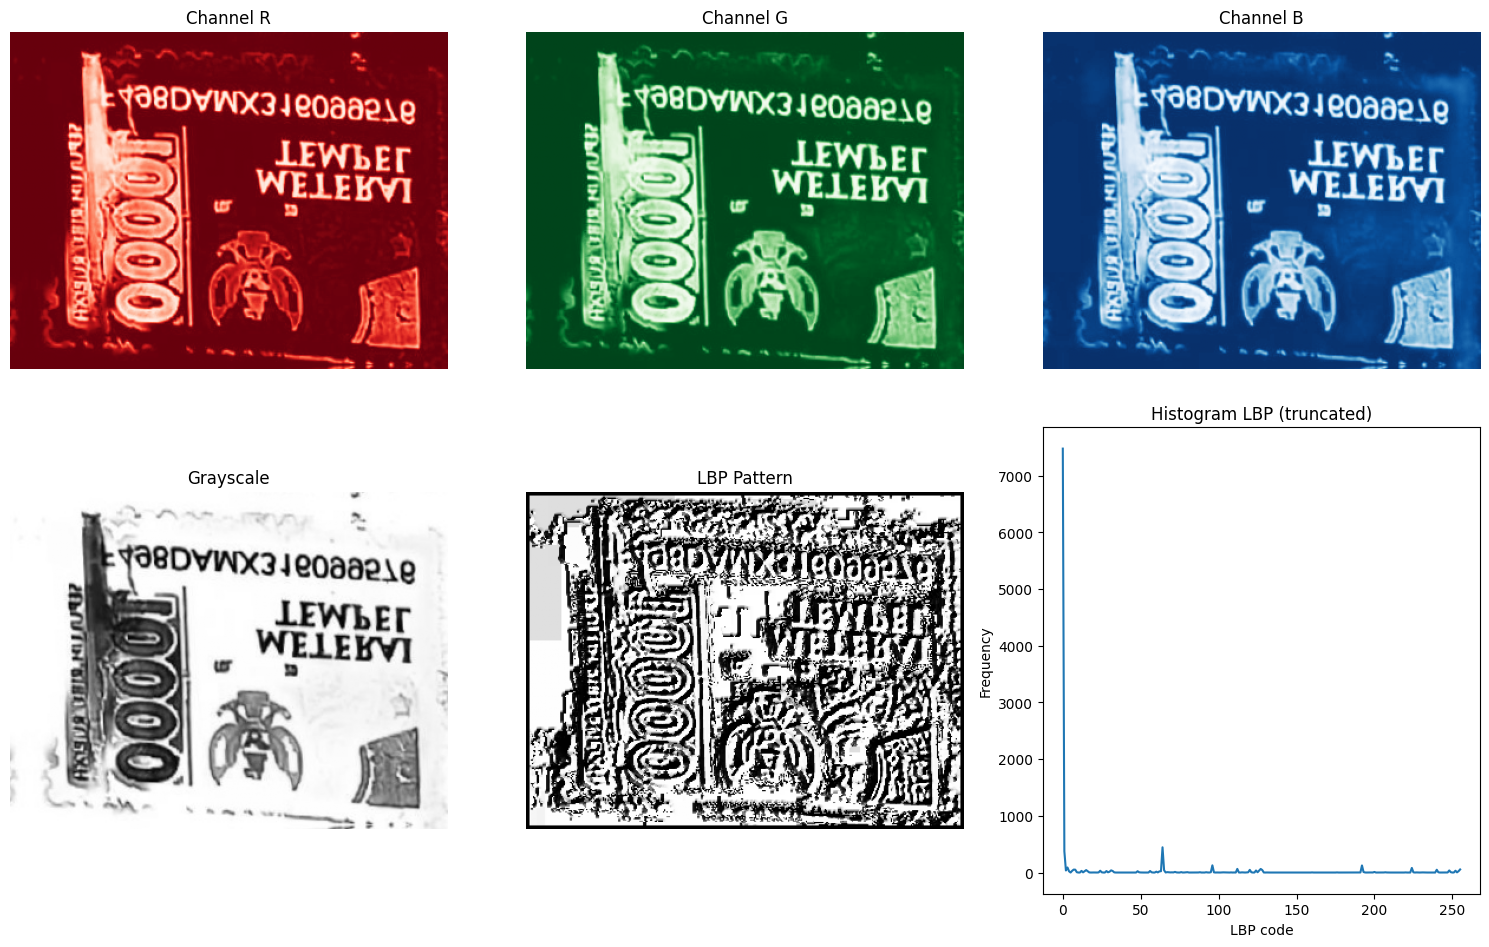

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 254, 252],
         [254, 254, 252],
         [254, 254, 252]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [254, 254, 252],
         [254, 254, 252],
         [255, 255, 253]],
 
        [[255, 255, 253],
         [255, 255, 253],
         [255, 255, 253],
         ...,
         [254, 254, 252],
         [255, 255, 253],
         [255, 255, 253]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [250, 247, 238],
         [250, 250, 242],
         [252, 251, 246]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [248, 245, 236],
         [250, 247, 240],
         [250, 249, 244]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [248, 245, 236],
  

In [ ]:
extractor.visualize_sample_processing("/content/drive/MyDrive/DATASET MATERAI/Asli/Netral/netral_clean/CamScanner 04-09-25 09.32_3_aug_4.jpg")

### MENGEKSTRAK FITUR SELURUH DATASET (TERLALU LAMA)

In [ ]:
dataset_path = "/content/drive/MyDrive/DATASET MATERAI"
extractor = MateraiFeatureExtractor()
df_features = extractor.process_dataset(dataset_path)

Menggunakan implementasi manual LBP...


KeyboardInterrupt: 

In [ ]:
stats = extractor.analyze_features(df_features)

❌ Dataset kosong!


### MENGGUNAKAN LIBRARY SCIKIT-IMAGE (UNTUK MEMPERCEPAT PROSES)

In [ ]:
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

class FeatureExtractor:
    def __init__(self, radius=3, n_points=24):
        self.radius = radius
        self.n_points = n_points

    def extract_lbp(self, gray):
        lbp = local_binary_pattern(gray, self.n_points, self.radius, method="uniform")
        return lbp.astype(np.uint8)

    def extract_glcm(self, gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
        # GLCM matrix
        glcm = graycomatrix(gray,
                            distances=distances,
                            angles=angles,
                            levels=256,
                            symmetric=True,
                            normed=True)

        # Ambil beberapa properti tekstur
        features = {
            "contrast": graycoprops(glcm, 'contrast').mean(),
            "dissimilarity": graycoprops(glcm, 'dissimilarity').mean(),
            "homogeneity": graycoprops(glcm, 'homogeneity').mean(),
            "energy": graycoprops(glcm, 'energy').mean(),
            "correlation": graycoprops(glcm, 'correlation').mean(),
            "ASM": graycoprops(glcm, 'ASM').mean()
        }
        return features

    def visualize_sample_processing(self, image_path):
        # 1. Baca gambar
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # 2. Grayscale
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

        # 3. LBP
        lbp_img = self.extract_lbp(gray)

        # 4. GLCM
        glcm_feats = self.extract_glcm(gray)

        # 5. Plot hasil
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # RGB
        axes[0, 0].imshow(image_rgb)
        axes[0, 0].set_title("Original RGB")
        axes[0, 0].axis('off')

        channels = ['R', 'G', 'B']
        cmaps = ['Reds', 'Greens', 'Blues']

        for i, cmap in enumerate(cmaps):
            channel_data = image_rgb[:, :, i]
            axes[0, i].imshow(channel_data, cmap=cmap)
            axes[0, i].set_title(f'Channel {channels[i]}')
            axes[0, i].axis('off')

        axes[1, 0].imshow(gray, cmap="gray")
        axes[1, 0].set_title("Grayscale")
        axes[1, 0].axis('off')

        axes[1, 1].imshow(lbp_img, cmap="gray")
        axes[1, 1].set_title("LBP (skimage)")
        axes[1, 1].axis('off')

        axes[1, 2].hist(lbp_img.ravel(), bins=np.arange(0, self.n_points+3), density=True)
        axes[1, 2].set_title("LBP Histogram")

        plt.tight_layout()
        plt.show()

        print("📊 GLCM Features:", glcm_feats)

        return image_rgb, lbp_img, glcm_feats

### COBA MELIHAT HASIL SALAH SATU GAMBAR

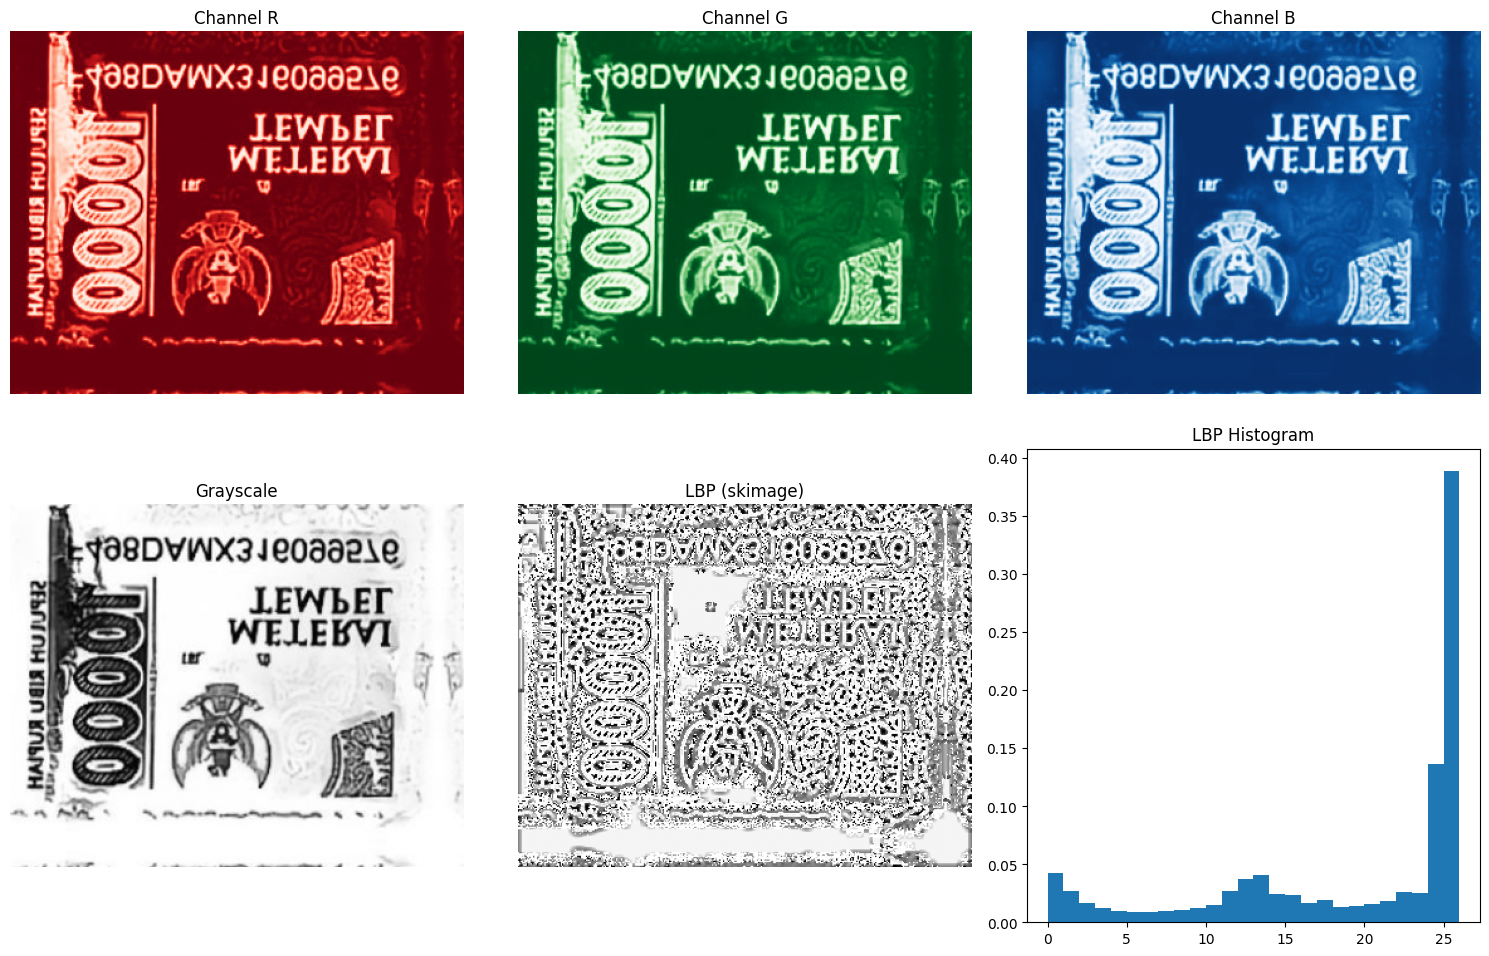

📊 GLCM Features: {'contrast': np.float64(948.8677476965267), 'dissimilarity': np.float64(14.851239805085454), 'homogeneity': np.float64(0.36855661454935995), 'energy': np.float64(0.1401607402492258), 'correlation': np.float64(0.9173724648378472), 'ASM': np.float64(0.01966068755029681)}


In [ ]:
extractor = FeatureExtractor(radius=3, n_points=24)
sample_path = "/content/drive/MyDrive/DATASET MATERAI/Asli/Netral/netral_clean/CamScanner 04-09-25 09.32_10_aug_1.jpg"
image_rgb, lbp_img, glcm_feats = extractor.visualize_sample_processing(sample_path)


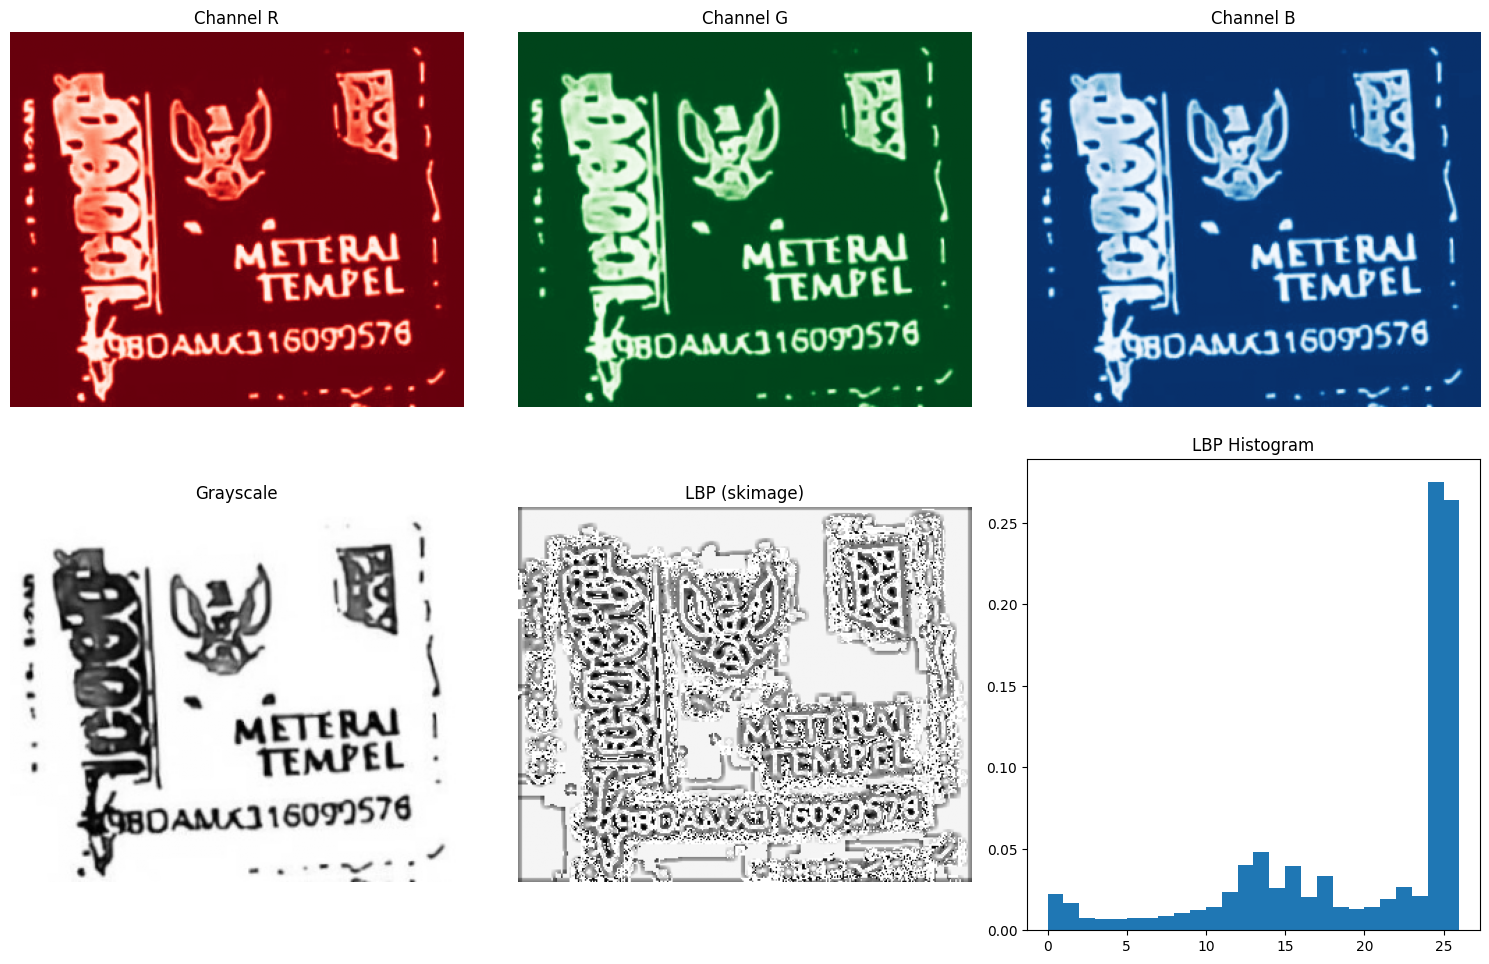

📊 GLCM Features: {'contrast': np.float64(734.5119092868106), 'dissimilarity': np.float64(11.256969712605258), 'homogeneity': np.float64(0.5647670378612795), 'energy': np.float64(0.33417905649204976), 'correlation': np.float64(0.938468138722633), 'ASM': np.float64(0.11171920367474064)}


In [ ]:

sample_path = "/content/drive/MyDrive/DATASET MATERAI/Palsu/Copy of CamScanner 07-09-25 09.32_10_aug_3.jpg"
image_rgb, lbp_img, glcm_feats = extractor.visualize_sample_processing(sample_path)

### MENGEKSTRAK SELURUH FITUR DI DATASET

In [ ]:
class MateraiFeatureExtractor:
    def __init__(self, radius=3, n_points=24):
        self.radius = radius
        self.n_points = n_points

    def extract_rgb_features(self, image):
        """Ekstrak statistik RGB"""
        b, g, r = cv2.split (image)

        rgb_features = {}
        for name, channel in zip(['R', 'G', 'B'], [r, g, b]):
            rgb_features[f'{name}_mean'] = np.mean(channel)
            rgb_features[f'{name}_std'] = np.std(channel)
            rgb_features[f'{name}_var'] = np.var(channel)
            rgb_features[f'{name}_min'] = np.min(channel)
            rgb_features[f'{name}_max'] = np.max(channel)
            rgb_features[f'{name}_median'] = np.median(channel)

        return rgb_features

    def extract_lbp_features(self, gray):
        """Ekstrak LBP + histogram"""
        lbp = local_binary_pattern(gray, self.n_points, self.radius, method="uniform")

        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)  # normalisasi

        lbp_features = {
            "LBP_mean": np.mean(lbp),
            "LBP_std": np.std(lbp),
            "LBP_var": np.var(lbp),
        }

        # tambahkan beberapa bin histogram sbg fitur
        num_bins_to_use = min(30, len(hist))
        for i in range(num_bins_to_use):
            lbp_features[f"LBP_hist_{i}"] = hist[i]

        return lbp_features

    def extract_glcm_features(self, gray):
        """Ekstrak fitur tekstur GLCM"""
        glcm = graycomatrix(
            gray,
            distances=[1, 2, 3],
            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
            levels=256,
            symmetric=True,
            normed=True
        )

        features = {}
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
        for prop in properties:
            values = graycoprops(glcm, prop)
            features[f'GLCM_{prop}_mean'] = values.mean()
            features[f'GLCM_{prop}_std'] = values.std()

        return features

    def extract_all_features(self, image_path, label):
        """Ekstrak semua fitur dari satu gambar"""
        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Tidak bisa membaca {image_path}")
            return None

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        rgb_feats = self.extract_rgb_features(image)
        lbp_feats = self.extract_lbp_features(gray)
        glcm_feats = self.extract_glcm_features(gray)

        all_features = {**rgb_feats, **lbp_feats, **glcm_feats}
        all_features["label"] = label
        all_features["image_path"] = image_path

        return all_features

    def process_dataset(self, dataset_path, save_csv=True, output_csv="materai_features.csv"):
        """Loop semua folder dataset (asli/palsu) dan simpan ke CSV"""
        data = []

        for label in ["Asli", "Palsu"]:
            folder = os.path.join(dataset_path, label)
            if not os.path.exists(folder):
                print(f"⚠️ Folder {folder} tidak ditemukan, dilewati")
                continue

            print(f"\n📂 Memproses folder: {label}")
            for file in tqdm(os.listdir(folder)):
                if file.lower().endswith((".jpg", ".jpeg", ".png")):
                    path = os.path.join(folder, file)
                    feats = self.extract_all_features(path, label)
                    if feats:
                        data.append(feats)

        df = pd.DataFrame(data)

        if save_csv and len(df) > 0:
            df.to_csv(output_csv, index=False)
            print(f"\n✅ Ekstraksi selesai!")
            print(f"📊 Total gambar: {len(df)}")
            print(f"🔢 Jumlah fitur: {len(df.columns)-2}")
            print(f"💾 Disimpan ke: {output_csv}")

        return df


### SIMPAN HASIL EKSTRAKSI KE DALAM FILE CSV

In [ ]:
extractor = MateraiFeatureExtractor(radius=3, n_points=24)

# dataset_path = "/content/drive/MyDrive/DATASET MATERAI"
# df_features = extractor.process_dataset(dataset_path, save_csv=True, output_csv="materai_features.csv")

## HASIL EKSTRAKSI

In [ ]:
hasil_ekstrak = pd.read_csv('materai_features.csv')
hasil_ekstrak.head(5)

R_mean      R_std        R_var  R_min  R_max  R_median      G_mean  \
0  223.763950  57.167199  3268.088594      0    255     252.0  214.690808   
1  225.549237  58.212423  3388.686219      0    255     254.0  218.704644   
2  223.227611  55.381203  3067.077668      1    255     252.0  214.079752   
3  224.923828  60.788345  3695.222873      0    255     254.0  217.908350   
4  220.196664  61.866299  3827.438932      0    255     253.0  212.194471   

       G_std        G_var  G_min  ...  GLCM_homogeneity_mean  \
0  69.002643  4761.364756      0  ...               0.390501   
1  68.317071  4667.222146      0  ...               0.498039   
2  67.362248  4537.672436      0  ...               0.380619   
3  70.837347  5017.929760      0  ...               0.493202   
4  72.328645  5231.432935      0  ...               0.425869   

   GLCM_homogeneity_std  GLCM_energy_mean  GLCM_energy_std  \
0              0.027278          0.205394         0.009219   
1              0.023752          0.278149         0.008794   
2              0.030787          0.188091         0.009655   
3              0.019866          0.273849         0.007668   
4              0.027745          0.211372         0.009260   

   GLCM_correlation_mean  GLCM_correlation_std  GLCM_ASM_mean  GLCM_ASM_std  \
0               0.750942              0.126082       0.042272      0.003797   
1               0.792766              0.107862       0.077444      0.004909   
2               0.778654              0.117857       0.035472      0.003646   
3               0.769560              0.112364       0.075052      0.004232   
4               0.801704              0.107943       0.044764      0.003946   

   label                                         image_path  
0   Asli  /content/drive/MyDrive/DATASET MATERAI/Asli/Co...  
1   Asli  /content/drive/MyDrive/DATASET MATERAI/Asli/Co...  
2   Asli  /content/drive/MyDrive/DATASET MATERAI/Asli/Co...  
3   Asli  /content/drive/MyDrive/DATASET MATERAI/Asli/Co...  
4   Asli  /content/drive/MyDrive/DATASET MATERAI/Asli/Co...  

[5 rows x 61 columns]

In [ ]:
hasil_ekstrak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   R_mean                   360 non-null    float64
 1   R_std                    360 non-null    float64
 2   R_var                    360 non-null    float64
 3   R_min                    360 non-null    int64  
 4   R_max                    360 non-null    int64  
 5   R_median                 360 non-null    float64
 6   G_mean                   360 non-null    float64
 7   G_std                    360 non-null    float64
 8   G_var                    360 non-null    float64
 9   G_min                    360 non-null    int64  
 10  G_max                    360 non-null    int64  
 11  G_median                 360 non-null    float64
 12  B_mean                   360 non-null    float64
 13  B_std                    360 non-null    float64
 14  B_var                    3

### PLOT RGB

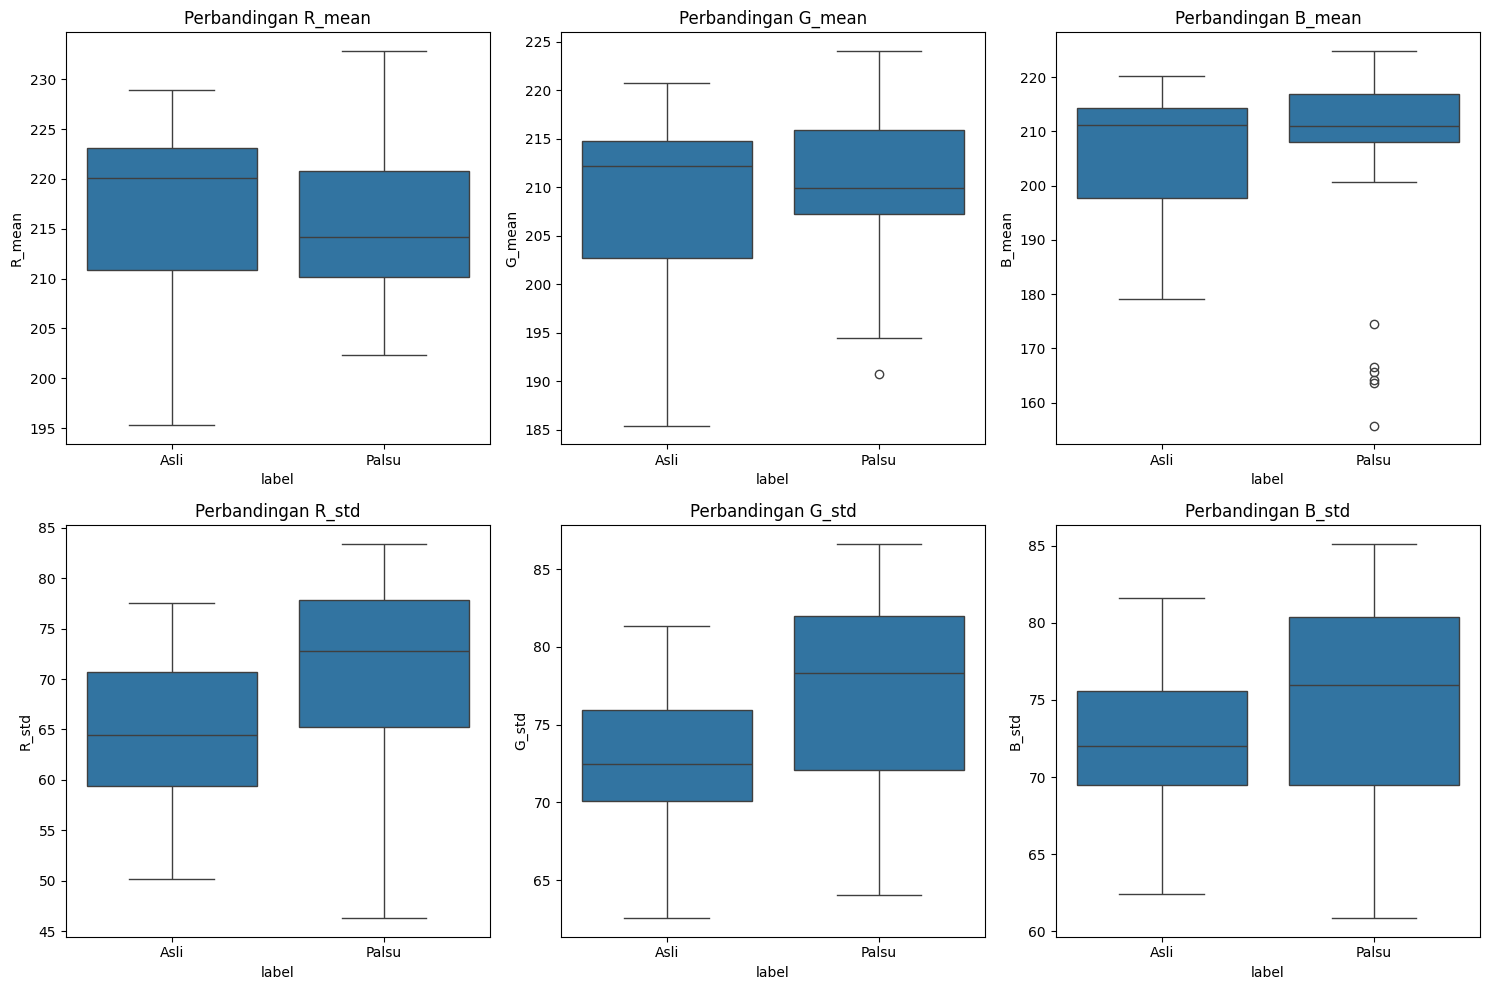

In [ ]:
rgb_features = ['R_mean', 'G_mean', 'B_mean', 'R_std', 'G_std', 'B_std']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(rgb_features):
    sns.boxplot(data=hasil_ekstrak, x='label', y=feature, ax=axes[i])
    axes[i].set_title(f'Perbandingan {feature}')

plt.tight_layout()
plt.show()

### PERBANDINGAN FITUR KEDUA MATERAI

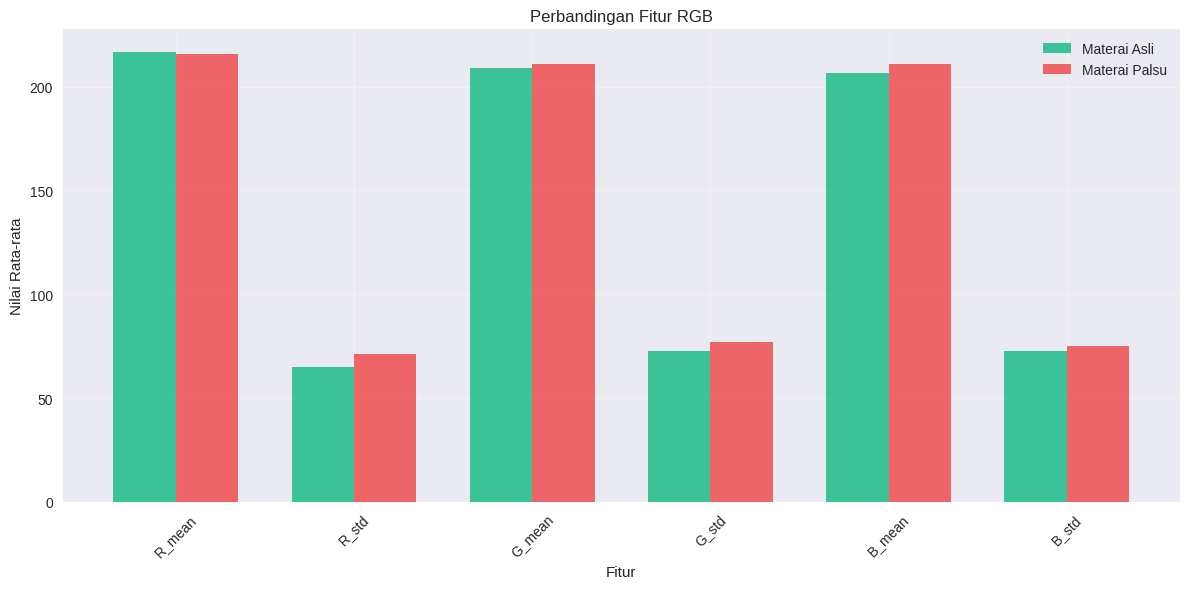

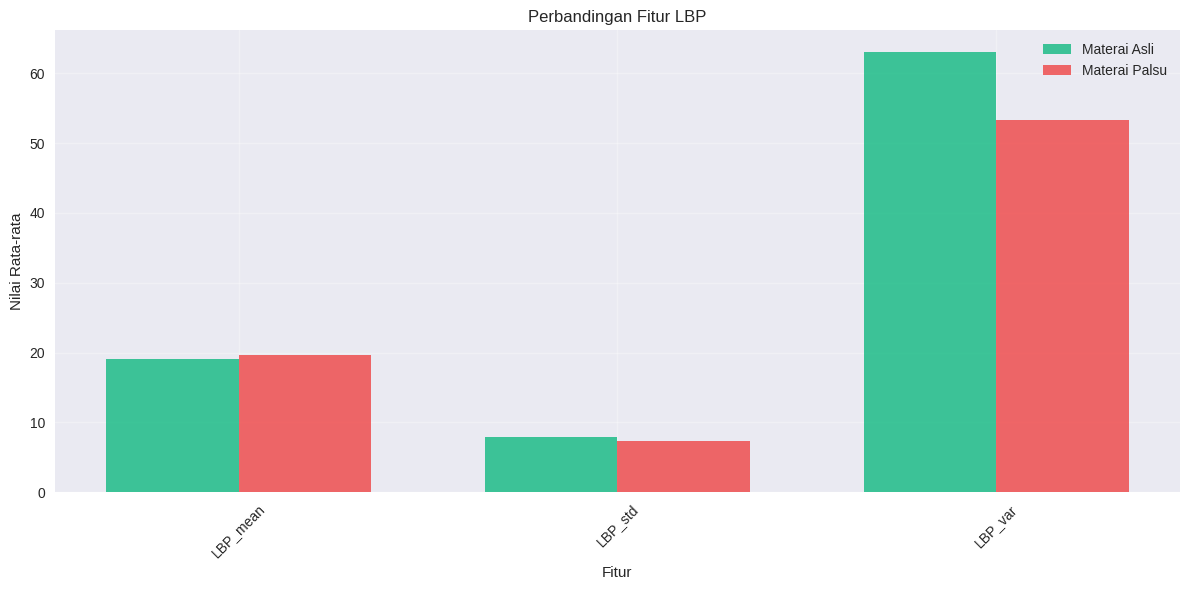

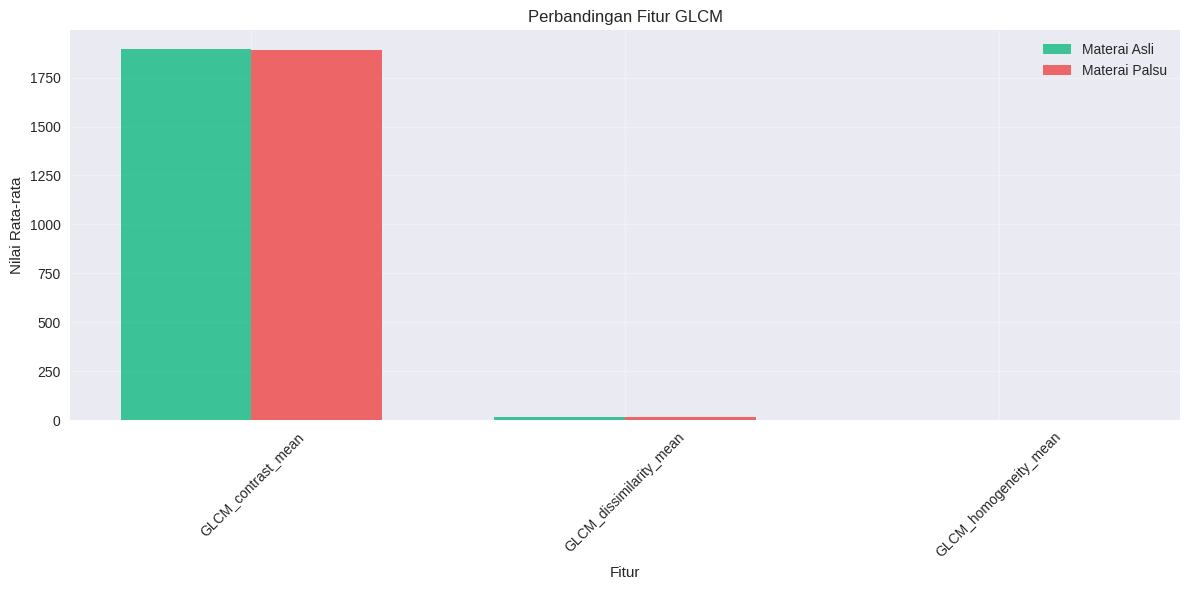

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

df = hasil_ekstrak
# Grup fitur
rgb_features = ['R_mean', 'R_std', 'G_mean', 'G_std', 'B_mean', 'B_std']
lbp_features = ['LBP_mean', 'LBP_std', 'LBP_var']
glcm_features = ['GLCM_contrast_mean', 'GLCM_dissimilarity_mean', 'GLCM_homogeneity_mean']

# Fungsi untuk membuat bar chart
def create_comparison_chart(features, title):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Hitung mean untuk setiap fitur berdasarkan label
    means_data = []
    for feature in features:
        asli_mean = df[df['label'] == 'Asli'][feature].mean()
        palsu_mean = df[df['label'] == 'Palsu'][feature].mean()
        means_data.append({
            'Feature': feature,
            'Asli': asli_mean,
            'Palsu': palsu_mean
        })

    means_df = pd.DataFrame(means_data)

    # Buat bar chart
    x = np.arange(len(features))
    width = 0.35

    bars1 = ax.bar(x - width/2, means_df['Asli'], width,
                   label='Materai Asli', color='#10B981', alpha=0.8)
    bars2 = ax.bar(x + width/2, means_df['Palsu'], width,
                   label='Materai Palsu', color='#EF4444', alpha=0.8)

    ax.set_xlabel('Fitur')
    ax.set_ylabel('Nilai Rata-rata')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Buat chart untuk setiap grup
create_comparison_chart(rgb_features, 'Perbandingan Fitur RGB')
create_comparison_chart(lbp_features, 'Perbandingan Fitur LBP')
create_comparison_chart(glcm_features, 'Perbandingan Fitur GLCM')

## **MELAKUKAN KLASIFIKASI**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### MEMBACA DATASET DAN NORMALISASI FITUR

In [6]:
# 1. Baca fitur dari CSV
df = pd.read_csv("materai_features.csv")

# 2. Pisahkan fitur dan label
X = df.drop(columns=["label", "image_path"])
y = df["label"]

# 3. Encode label (asli/palsu -> 0/1)
le = LabelEncoder()
y = le.fit_transform(y)

# 4. Normalisasi fitur (biar skala setara)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### MELAKUKAN SPLIT DATA TRAINING DAN TESTING

In [ ]:
# 5. Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Check the distribution of classes in train and test sets
print("Class distribution in y_train:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
print(dict(zip(le.inverse_transform(unique_train), counts_train)))

print("\nClass distribution in y_test:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(dict(zip(le.inverse_transform(unique_test), counts_test)))

Class distribution in y_train:
{'Asli': np.int64(144), 'Palsu': np.int64(144)}

Class distribution in y_test:
{'Asli': np.int64(36), 'Palsu': np.int64(36)}


### MENGGUNAKAN RANDOM FOREST


Random Forest Performance
Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

        Asli       0.92      1.00      0.96        36
       Palsu       1.00      0.92      0.96        36

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72



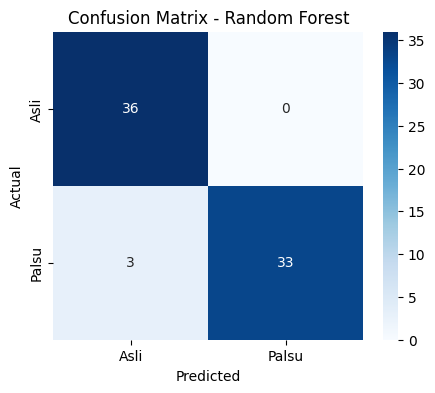

In [ ]:
# =====================
# 🔹 Random Forest
# =====================
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d",
            cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### MENGGUNAKAN SUPPORT VECTOR MACHINE (SVM)


🎯 SVM Performance
Accuracy: 0.9861111111111112
              precision    recall  f1-score   support

        Asli       0.97      1.00      0.99        36
       Palsu       1.00      0.97      0.99        36

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



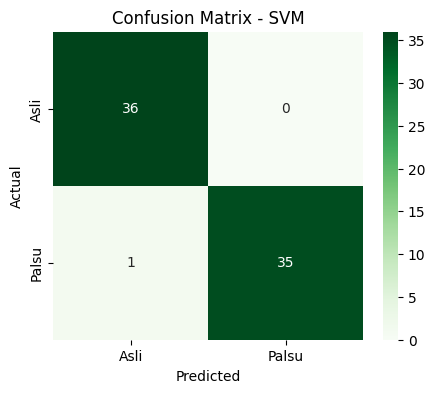

In [ ]:
# =====================
# 🔹 Support Vector Machine (SVM)
# =====================

# Check if y_train has more than one class before training SVM
if len(np.unique(y_train)) < 2:
    print("\n⚠️ SVM training skipped: y_train contains only one class.")
else:
    svm = SVC(kernel="rbf", C=10, gamma=0.01, probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)

    print("\n🎯 SVM Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred_svm))
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d",
                cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix - SVM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Feature Importance

Untuk melihat fitur mana yang paling berpengaruh membedakan materai asli vs palsu

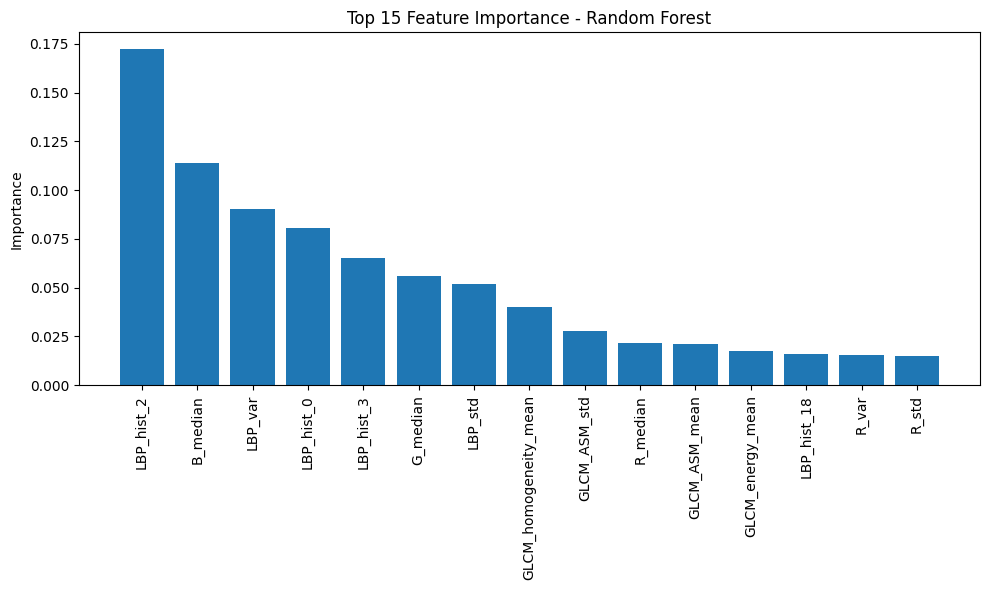

In [ ]:
# =====================
# 🔹 Feature Importance dari Random Forest
# =====================

feature_names = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # urutkan descending

# Plot 15 fitur teratas
plt.figure(figsize=(10,6))
plt.title("Top 15 Feature Importance - Random Forest")
plt.bar(range(15), importances[indices[:15]], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()



--- Ringkasan Hasil Klasifikasi ---

Random Forest Classifier:
Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

        Asli       0.92      1.00      0.96        36
       Palsu       1.00      0.92      0.96        36

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72


Support Vector Machine (SVM):
Accuracy: 0.9861111111111112
              precision    recall  f1-score   support

        Asli       0.97      1.00      0.99        36
       Palsu       1.00      0.97      0.99        36

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



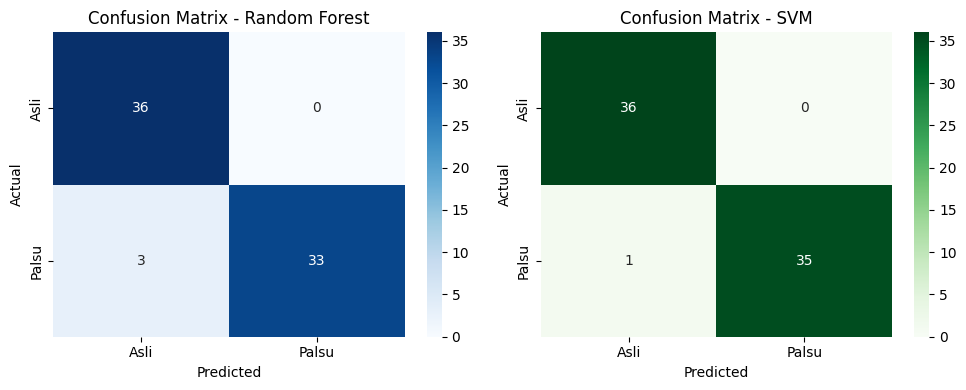

In [ ]:
# =====================
# 📊 Ringkasan Performa Klasifikasi
# =====================

print("\n--- Ringkasan Hasil Klasifikasi ---")

print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print("\nSupport Vector Machine (SVM):")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Tampilkan kembali confusion matrix untuk kedua model
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d",
            cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d",
            cmap="Greens", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

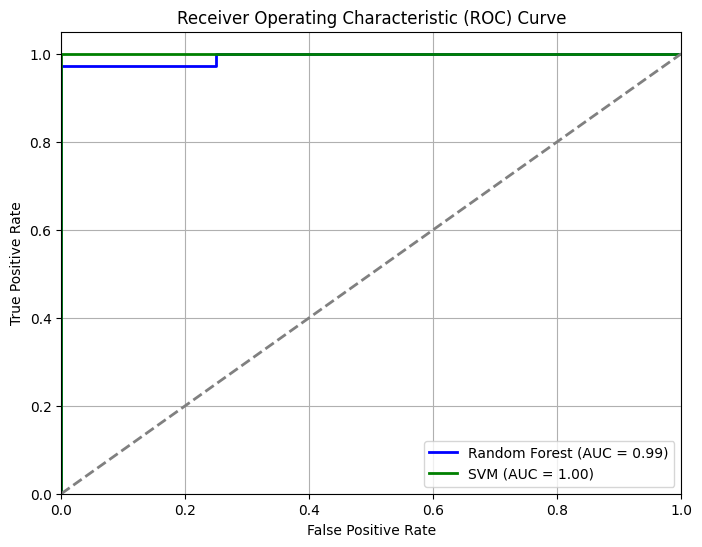

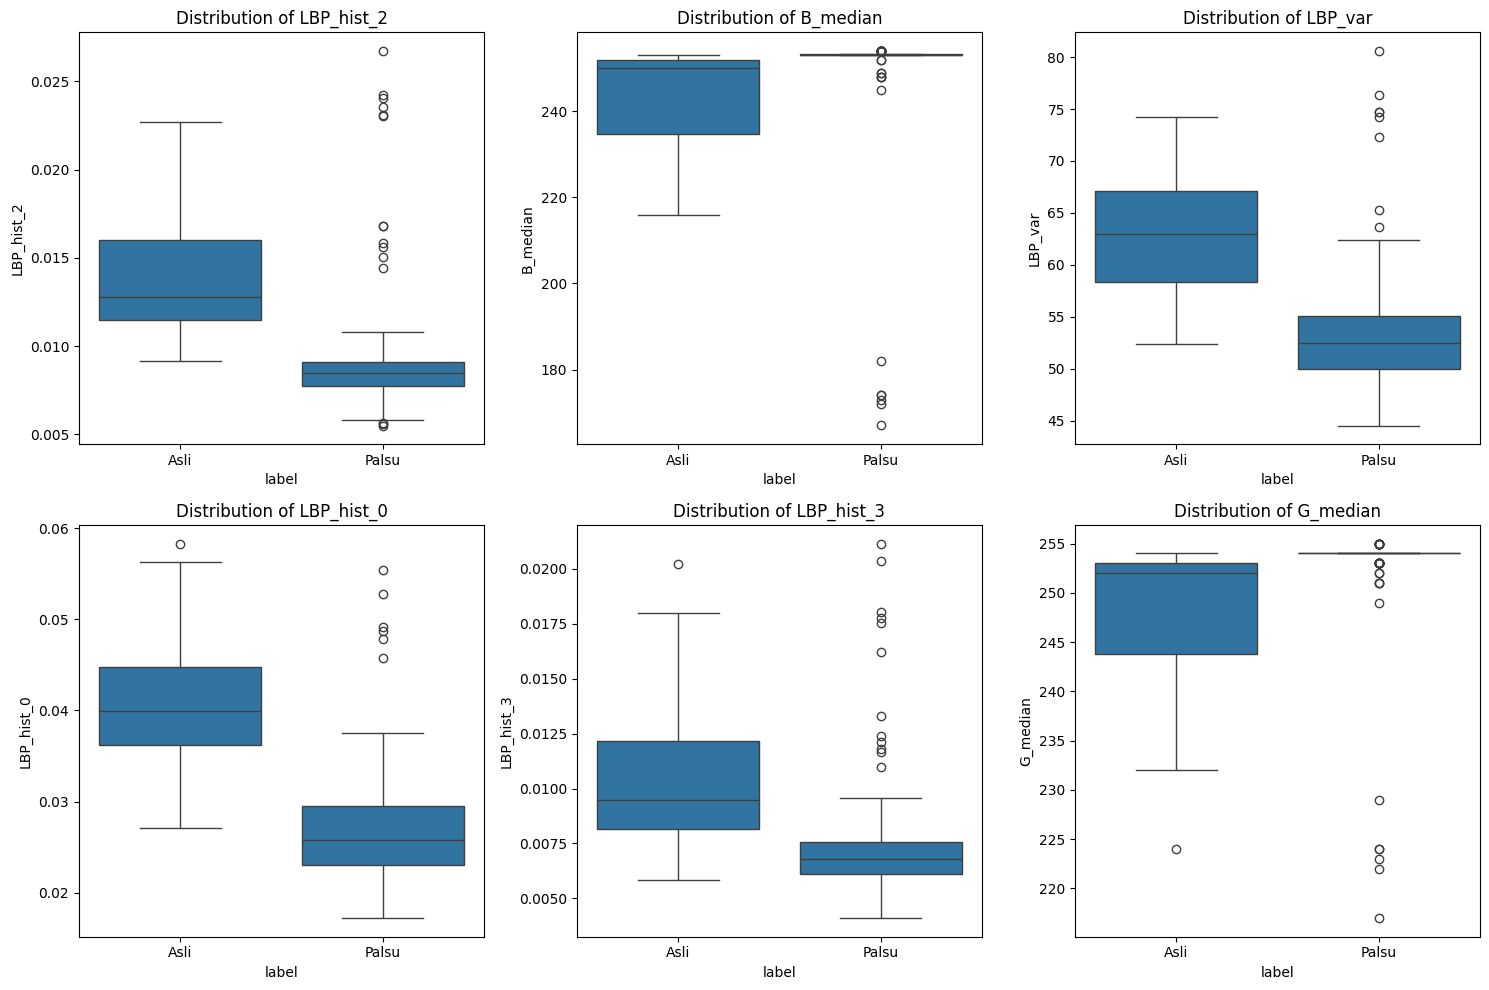

In [ ]:
from sklearn.metrics import roc_curve, auc

# =====================
# 📊 Visualisasi Tambahan
# =====================

# 1. ROC Curve
plt.figure(figsize=(8, 6))

# Random Forest
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# SVM
if len(np.unique(y_train)) >= 2: # Ensure SVM was trained
    y_prob_svm = svm.predict_proba(X_test)[:, 1]
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# 2. Distribusi Fitur Penting (Menggunakan top features dari RF)
# Ambil top 6 fitur dari Random Forest (sesuai plot sebelumnya)
feature_names = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_feature_names = [feature_names[i] for i in indices[:6]] # Top 6 features

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_feature_names):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, x='label', y=feature)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

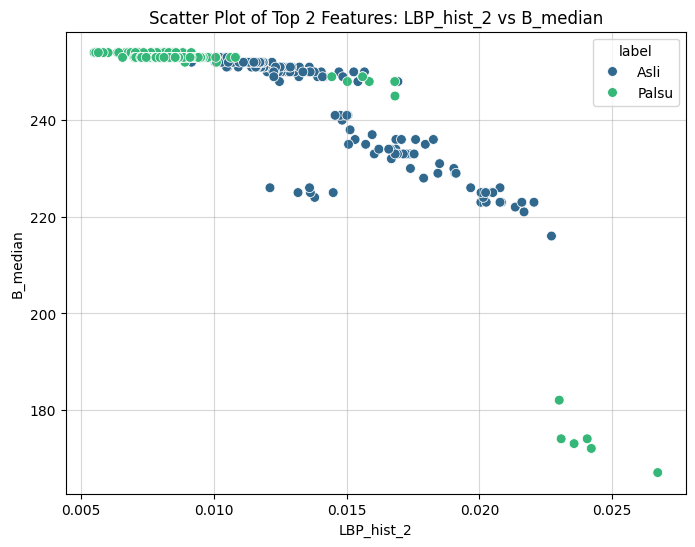

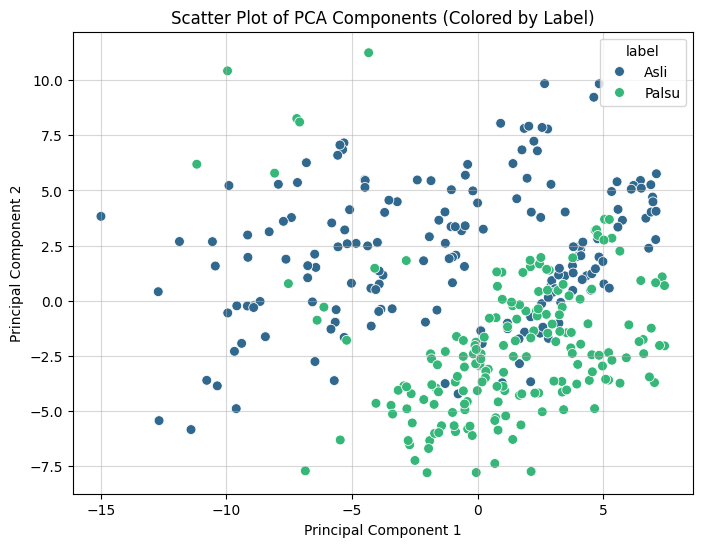

In [ ]:
# =====================
# 📊 Visualisasi Scatter Plot Fitur Penting
# =====================

# Ambil 2 fitur teratas dari Random Forest untuk visualisasi scatter plot 2D
feature_names = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_2_feature_names = [feature_names[i] for i in indices[:2]]

if len(top_2_feature_names) == 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=top_2_feature_names[0], y=top_2_feature_names[1], hue='label', palette='viridis', s=50)
    plt.title(f'Scatter Plot of Top 2 Features: {top_2_feature_names[0]} vs {top_2_feature_names[1]}')
    plt.xlabel(top_2_feature_names[0])
    plt.ylabel(top_2_feature_names[1])
    plt.grid(True, alpha=0.5)
    plt.show()
else:
    print("Tidak dapat membuat scatter plot 2D karena kurang dari 2 fitur teratas tersedia.")

# Jika ada lebih dari 2 fitur teratas, bisa juga menggunakan PCA untuk visualisasi 2D
if X_scaled.shape[1] > 2:
    from sklearn.decomposition import PCA
    pca_scatter = PCA(n_components=2)
    X_pca_scatter = pca_scatter.fit_transform(X_scaled)

    pca_df = pd.DataFrame(X_pca_scatter, columns=['PCA1', 'PCA2'])
    pca_df['label'] = df['label'] # Tambahkan kembali label

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='label', palette='viridis', s=50)
    plt.title('Scatter Plot of PCA Components (Colored by Label)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.5)
    plt.show()
else:
     print("Tidak cukup fitur untuk melakukan PCA dan membuat scatter plot 2D.")

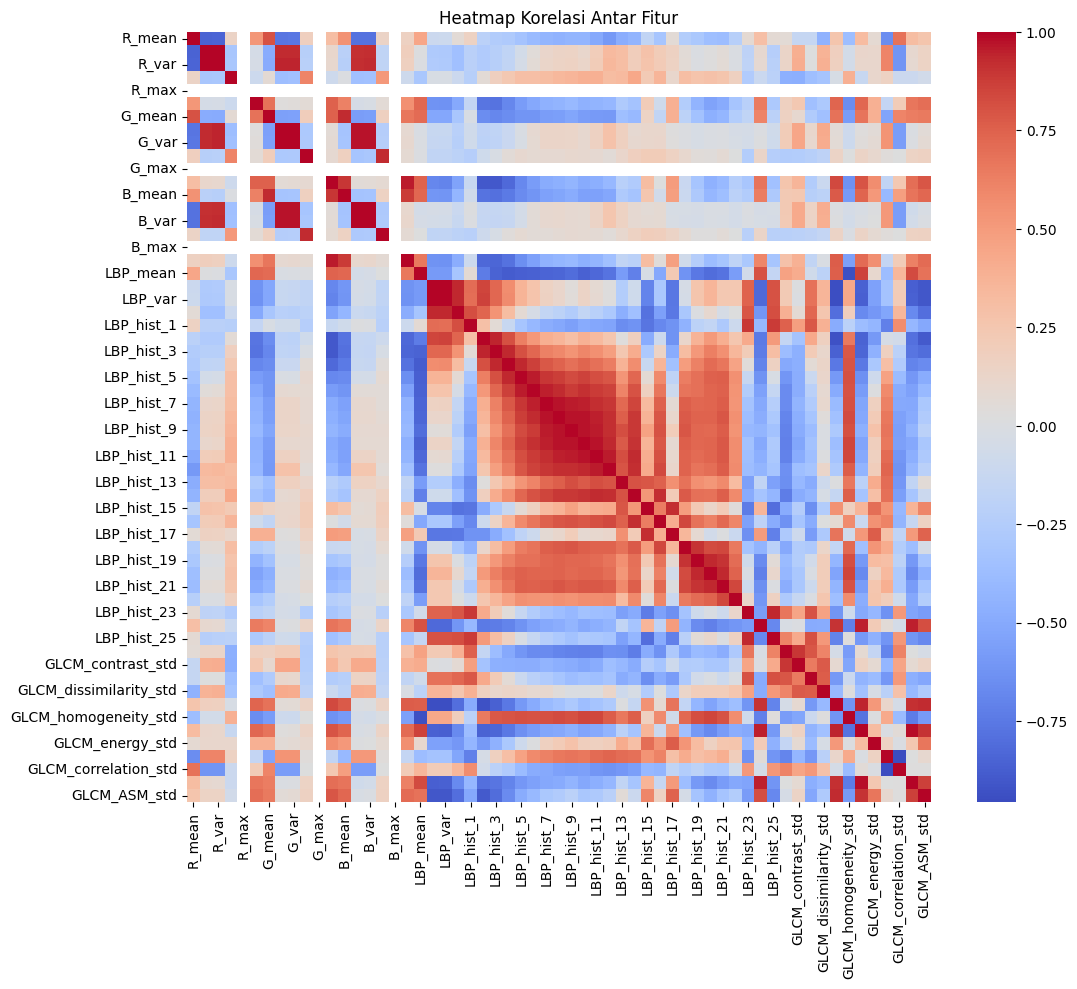

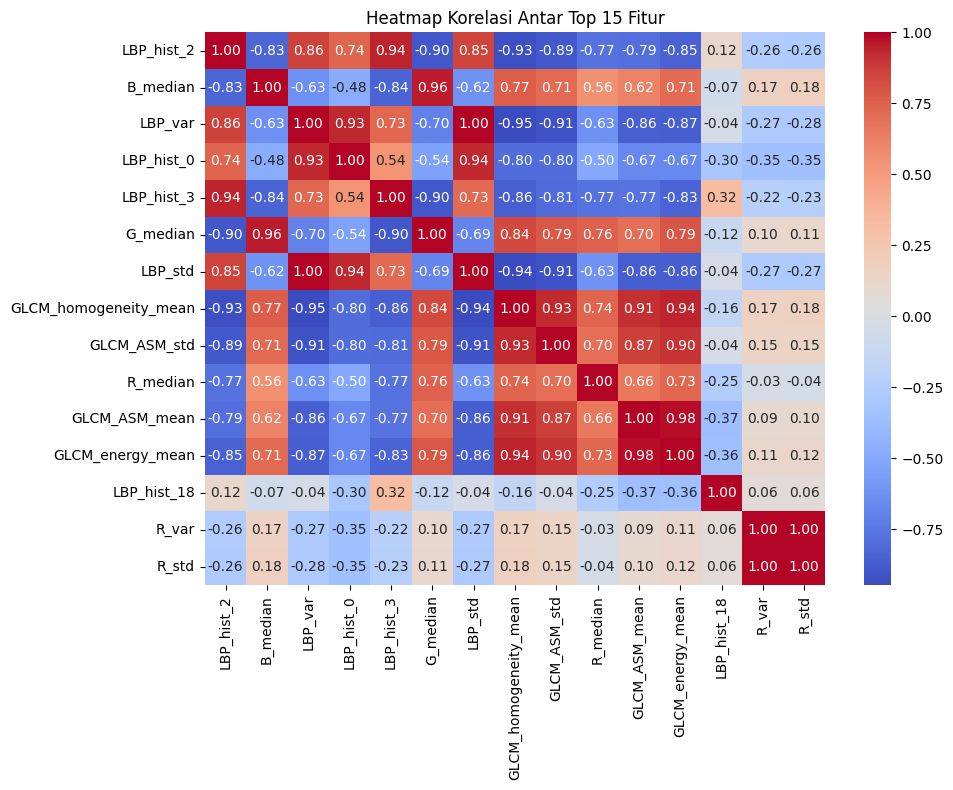

In [ ]:
# =====================
# 📊 Visualisasi Heatmap Korelasi Fitur
# =====================

# Pilih hanya fitur numerik untuk heatmap korelasi
df_numeric = df.select_dtypes(include=np.number)

# Hitung matriks korelasi
correlation_matrix = df_numeric.corr()

# Buat heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False) # non-annotated for clarity with many features
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

# Untuk heatmap dengan anotasi pada subset fitur teratas (misalnya top 15 dari RF)
feature_names = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_15_feature_names = [feature_names[i] for i in indices[:15]]

# Filter dataframe hanya untuk fitur teratas
df_top_features = df[top_15_feature_names]
correlation_matrix_top = df_top_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_top, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap Korelasi Antar Top 15 Fitur')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## **PREDIKSI**

In [ ]:
import cv2
import joblib

# Simpan model dan scaler (sekali saja setelah training)
joblib.dump(rf, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

# Load kembali saat prediksi
rf_loaded = joblib.load("rf_model.pkl")
scaler_loaded = joblib.load("scaler.pkl")
le_loaded = joblib.load("label_encoder.pkl")

def predict_new_image(image_path, model, scaler, label_encoder):
    """
    Prediksi label (asli/palsu) untuk gambar baru.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Gagal membaca gambar: {image_path}")

    # Konversi ke grayscale untuk LBP dan GLCM
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ekstraksi fitur pakai extractor yang sudah kamu buat
    rgb_feats = extractor.extract_rgb_features(image)
    lbp_feats = extractor.extract_lbp_features(gray)
    glcm_feats = extractor.extract_glcm_features(gray)
    all_features = {**rgb_feats, **lbp_feats, **glcm_feats}
    feature_df = pd.DataFrame([all_features])


    # Skala data
    feature_scaled = scaler.transform(feature_df)

    # Prediksi
    y_pred = model.predict(feature_scaled)
    label = label_encoder.inverse_transform(y_pred)[0]

    return label

In [ ]:
#@title Tes prediksi gambar baru (dengan materai asli)

test_image_asli = "/content/drive/MyDrive/DATASET MATERAI/Asli/Copy of CamScanner 04-09-25 09.36_10_aug_1.jpg"
hasil_prediksi = predict_new_image(test_image_asli, rf_loaded, scaler_loaded, le_loaded)

print(f"Hasil Prediksi: {hasil_prediksi}")

Hasil Prediksi: Asli


In [ ]:
#@title Tes prediksi gambar baru (dengan materai palsu)

test_image_palsu = "/content/drive/MyDrive/DATASET MATERAI/Palsu/Copy of CamScanner 07-09-25 09.32_1_aug_1.jpg"
hasil_prediksi = predict_new_image(test_image_palsu, rf_loaded, scaler_loaded, le_loaded)

print(f"Hasil Prediksi: {hasil_prediksi}")

Hasil Prediksi: Palsu
